# Perbandingan Model Segmentasi untuk Masking Sampah dan Generatif untuk Menghilangkan Objek Sampah pada Gambar

**Anggota Kelompok:**
* 222200153 - Christopher Nathaniel Tanamas
* 222102311 - Elaine Evelyn
* 222102176 - Grace Calista Lim
* 222101393 - Jemima Alithia Sigar

Proyek ini berangkat dari ketidaksadaran masyarakat akan pentingnya menjaga kebersihan lingkungan. Sampah yang sering dianggap hal kecil berdampak besar pada kenyamanan, estetika, dan kesehatan masyarakat. Dengan memanfaatkan teknologi computer vision untuk mendeteksi dan mensimulasikan keadaan lingkungan tanpa sampah, proyek ini dapat menunjukkan perbedaan nyata antara lingkungan kotor dan bersih. Melalui pendekatan ini, diharapkan masyarakat dapat lebih sadar bahwa lingkungan yang rapi dan bersih harus dijaga bersama.

Dalam pemodelannya, kami membandingkan dua model segmentasi, yaitu Segformer dan DPT untuk mensegmentasi sampah secara akurat. Hasil masking ini kemudian digunakan oleh dua model generatif, yaitu Stable Difussion dan ControlNet untuk menghapus sampah dan mengisi area kosong dengan latar belakang yang natural. Pendekatan dua tahap ini memungkinkan sistem membersihkan gambar tanpa merusak detail penting lainnya.

Dataset yang digunakan adalah TACO (Trash Annotations in Context) untuk melatih model diskriminatif (segmentasi) maupun generatif.

# Data Preparation

## Download Images & Masks dataset
Dataset diambil dari TACO (Trash Annotations in Context), sebuah dataset open-source yang berisi gambar sampah pada lingkungan nyata. TACO menggunakan COCO-style annotation, di mana seluruh informasi anotasi disimpan dalam sebuah file JSON terpusat. Pada file JSON tersebut, terdapat sekitar 2.398 pasang gambar dan mask yang dapat digunakan untuk pelatihan model kami.

Dataset dapat diakses melalui repositori resmi TACO di GitHub: https://github.com/pedropro/TACO

### Import Libraries

In [ ]:
import os
import json
import requests
from urllib.parse import urlparse
from tqdm import tqdm
import numpy as np
from PIL import Image
from pycocotools.coco import COCO
import cv2
from tqdm import tqdm

### Config Folder Location

In [ ]:
# Config
data_dir = "data"
images_dir = "images"
masks_dir = "masks"
ann_file = os.path.join(data_dir, "annotations_unofficial.json")

# Buat folder jika belum ada
os.makedirs(images_dir, exist_ok=True)
os.makedirs(masks_dir, exist_ok=True)

### Download Images and Masks

In [ ]:
# Load JSON annotations
with open(ann_file) as f:
    annotations = json.load(f)

# Buat dictionary (berdasarkan JSON pada annotations)
url_to_file = {}
for img in annotations['images']:
    jpg_url = img.get('flickr_640_url')
    if not jpg_url:
        continue
    basename = os.path.basename(urlparse(jpg_url).path)
    url_to_file[basename] = img['file_name']    # image asli dalam bentuk jpg

# Load COCO annotations
coco = COCO(ann_file)

# Download & Generate Mask
for basename, file_name_json in tqdm(url_to_file.items(), desc="Processing images & masks"):

    # Sesuaikan image dengan yang ada pada annotations
    jpg_url = next((img['flickr_640_url'] for img in annotations['images'] if img['file_name'] == file_name_json), None)
    if not jpg_url:
        continue

    # Cari gambar di direktori penyimpanan
    jpg_path = os.path.join(images_dir, basename)

    # Kalau gambar belum ada, download dulu
    if not os.path.exists(jpg_path):
        try:
            r = requests.get(jpg_url, timeout=10)
            if r.status_code == 200:
                with open(jpg_path, "wb") as f:
                    f.write(r.content)
            else:
                print(f"Failed to download image: {jpg_url}")
                continue
        except Exception as e:
            print(f"Error downloading image {jpg_url}: {e}")
            continue

    # Cari img_id di COCO
    img_id_list = coco.getImgIds()
    img_id = next((i for i in img_id_list if coco.loadImgs(i)[0]['file_name'] == file_name_json), None)
    if img_id is None:
        print(f"Image {file_name_json} not found in COCO annotations.")
        continue

    # Load image lokal untuk ukuran asli
    img_pil = Image.open(jpg_path)
    img_width, img_height = img_pil.size

    # Generate mask berdasarkan data dari annotations
    mask = np.zeros((img_height, img_width), dtype=np.uint8)
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)
    for ann in anns:
        try:
            # Periksa apakah gambar punya segmentasi atau tidak
            if 'segmentation' not in ann or not ann['segmentation']:
                continue
            
            ann_mask = coco.annToMask(ann)  # Ubah mask menjadi biner (1/0)

            # Resize mask ke ukuran image lokal
            mask_pil = Image.fromarray(ann_mask*255)
            mask_pil = mask_pil.resize((img_width, img_height), resample=Image.NEAREST)
            ann_mask_resized = np.array(mask_pil) // 255
            mask = np.maximum(mask, ann_mask_resized)
        except (IndexError, Exception) as e:
            print(f"Warning: Skipping annotation for {file_name_json}: {e}")
            continue
        
    # convert 1 -> 255 (sampah putih, background hitam)
    mask = mask * 255 

    # Save mask dalam bentuk png
    mask_filename = os.path.splitext(basename)[0] + ".png"
    mask_path = os.path.join(masks_dir, mask_filename)
    Image.fromarray(mask).save(mask_path)

## Augmentasi
Kode berikut melakukan augmentasi pada dataset gambar dan mask segmentasi. Setiap gambar akan digandakan beberapa kali menggunakan transformasi seperti horizontal flip, brightness/contrast, dan rotasi. Setelah proses augmentasi, dataset yang digunakan bertambah 3x lipat dari jumlah awal, yaitu sekitar 7.194 gambar (1 gambar asli + 2 gambar augmentasi), baik untuk images dan masks

### Import Libraries

In [ ]:
import os
import cv2
import albumentations as A
from google.colab import drive

### Config Folder Location

In [ ]:
drive.mount('/content/drive')

# Path dataset
image_dir = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/images"
mask_dir  = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/masks"

# Folder output hasil augmentasi
output_img_dir = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/images_aug"
output_mask_dir = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/masks_aug"

os.makedirs(output_img_dir, exist_ok=True)
os.makedirs(output_mask_dir, exist_ok=True)

### Augmentation Process

In [ ]:
# Augmenter
augmenter = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=15, p=0.5)
], additional_targets={'mask': 'mask'})

# Menambahkan 2 augmentasi untuk setiap gambar
augment_count = 2
all_images = sorted(os.listdir(image_dir))

# Augmentasi setiap gambar
for img_name in all_images:
    # buat nama untuk mask (dalam bentuk png)
    img_path = os.path.join(image_dir, img_name)
    base_name = os.path.splitext(img_name)[0]
    mask_name = f"{base_name}.png"
    mask_path = os.path.join(mask_dir, mask_name)

    # Periksa apakah mask ada atau tidak
    if not os.path.exists(mask_path):
        print("❌ Mask not found for:", img_name)
        continue

    # Load image dan mask
    image = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    base = img_name.split(".")[0]
    out_img_original = f"{base}_0.jpg"
    out_mask_original = f"{base}_0.png"

    cv2.imwrite(os.path.join(output_img_dir, out_img_original), image)
    cv2.imwrite(os.path.join(output_mask_dir, out_mask_original), mask)

    # Generate augmentasi
    for i in range(augment_count):

        augmented = augmenter(image=image, mask=mask)
        aug_img = augmented["image"]
        aug_mask = augmented["mask"]

        out_img = f"{base}_aug_{i+1}.jpg"
        out_mask = f"{base}_aug_{i+1}.png"

        cv2.imwrite(os.path.join(output_img_dir, out_img), aug_img)
        cv2.imwrite(os.path.join(output_mask_dir, out_mask), aug_mask)

## Clean Image

In [ ]:
image_dir = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/images"
mask_dir  = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/masks"
output_dir = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/clean"

os.makedirs(output_dir, exist_ok=True)

image_files = sorted(os.listdir(image_dir))

for img_name in tqdm(image_files):
    img_path = os.path.join(image_dir, img_name)
    mask_path = os.path.join(mask_dir, img_name)

    if not os.path.exists(mask_path):
        print(f"Mask not found for {img_name}, skip.")
        continue

    # load image
    image = cv2.imread(img_path)
    mask = cv2.imread(mask_path, 0)  # grayscale

    if image is None or mask is None:
        print(f"Error loading {img_name}")
        continue

    # inpaint area sample
    clean = cv2.inpaint(image, mask, 3, cv2.INPAINT_TELEA)

    # save clean result
    out_path = os.path.join(output_dir, img_name)
    cv2.imwrite(out_path, clean)


Mounted at /content/drive


100%|██████████| 2398/2398 [13:45<00:00,  2.90it/s]


# Diskriminatif (Segmentasi)
Pada tahap diskriminatif, kami membandingkan dua model: Segformer dan DPT untuk proses segmentasi sampah. Kedua model ini dipilih karena dapat melakukan semantic segmentation pada dataset sampah yang kami miliki.

## Segformer
Pada eksperimen ini, kami menggunakan SegFormer-B0 yang telah fine-tuned pada dataset ADE20K. Versi B0 merupakan varian paling kecil, sehingga lebih cepat untuk pelatihan dan inferensi sambil tetap mempertahankan akurasi yang kompetitif. Varian ini memiliki paramater berjumlah sekitar 3.8 juta parameter.

Model ini kami ambil dari HuggingFace: https://huggingface.co/nvidia/segformer-b0-finetuned-ade-512-512

![image.png](markdown_image/segformer.png)

### Import Libraries

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
from google.colab import drive, files
import matplotlib.pyplot as plt

### Cuda (GPU) Initialization

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Mount Google Drive & Access Dataset

In [ ]:
drive.mount('/content/drive')

# Path dataset
image_dir = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/images_aug"
mask_dir  = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/masks_aug"

### Custom Dataset for Trash Segmentation

In [ ]:
class TrashDataset(Dataset):
    def __init__(self, image_list, mask_list, image_dir, mask_dir, processor):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.processor = processor
        self.images = image_list
        self.masks  = mask_list

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # load image
        image = Image.open(os.path.join(self.image_dir, self.images[idx])).convert("RGB")

        # load mask
        mask = Image.open(os.path.join(self.mask_dir, self.masks[idx]))
        mask = np.array(mask)
        labels = (mask > 0).astype(np.int64)    # labels: sampah=1, background=0

        # encoding image dan label (Processor menangani resizing dan alignment)
        encoding = self.processor(
            images=image,
            segmentation_maps=labels,
            return_tensors="pt"
        )

        # squeeze untuk hilangkan batch (nanti akan diterapkan pada data loader)
        pixel_values = encoding["pixel_values"].squeeze(0)
        labels = encoding["labels"].squeeze(0)

        return {"pixel_values": pixel_values, "labels": labels}

### Train Test Split

In [ ]:
# Train / Validation (test) split
all_images = sorted(os.listdir(image_dir))
all_masks  = sorted(os.listdir(mask_dir))

train_images, val_images, train_masks, val_masks = train_test_split(
    all_images, all_masks, test_size=0.2, random_state=42
)

### Load Processor and Model

In [ ]:
processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512"
)

# Ubah channel classifier untuk mengklasifikasi hanya 2 kelas: sampah dan background
in_channels = model.decode_head.classifier.in_channels 
model.decode_head.classifier = nn.Conv2d(in_channels, 2, kernel_size=1)

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

### Create Data Loader

In [ ]:
train_dataset = TrashDataset(train_images, train_masks, image_dir, mask_dir, processor)
val_dataset   = TrashDataset(val_images, val_masks, image_dir, mask_dir, processor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### Loss Criterion

#### DiceLoss
Gunakan DiceLoss karena kita ingin mensegmentasi sampah yang cenderung memiliki area lebih kecil dibandingkan background. 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth    # biar hasilnya ga NaN

    def forward(self, logits, targets):
        B, C, H, W = logits.shape

        # Convert labels to one-hot    
        targets_one_hot = F.one_hot(targets, num_classes=C).permute(0, 3, 1, 2).float()

        # Softmax -> probabilities
        probs = torch.softmax(logits, dim=1)

        # Flatten
        probs = probs.view(B, C, -1)
        targets_one_hot = targets_one_hot.view(B, C, -1)

        # Intersection & union
        intersection = (probs * targets_one_hot).sum(dim=2)
        union = probs.sum(dim=2) + targets_one_hot.sum(dim=2)

        dice_score = (2 * intersection + self.smooth) / (union + self.smooth)

        # Hanya foreground = kelas 1 (sampah) yang dihitung
        dice_loss = 1 - dice_score[:, 1]  # kelas 1 = foreground

        return dice_loss.mean()


#### Gabungkan DiceLoss dengan Cross Entropy

In [ ]:
# Tentukan Bobot 
class_weights_cel = torch.tensor([0.05, 0.95]).to(device) # 0.05 untuk background, 0.95 untuk sampah

# Definisikan komponen Loss
cel_criterion = nn.CrossEntropyLoss(weight=class_weights_cel)
dice_criterion = DiceLoss()

# Tentukan bobot loss
ALPHA = 0.3  # CE 30%, Dice 70%

def hybrid_loss_criterion(logits_upsampled, labels):
    loss_cel = cel_criterion(logits_upsampled, labels)
    loss_dice = dice_criterion(logits_upsampled, labels)

    return (ALPHA * loss_cel) + ((1 - ALPHA) * loss_dice)   # total loss

### Load Optimizer

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

### Evaluation Matrix per Epoch (IoU)
$\text{IoU}_{c} = \frac{|P_c \cap G_c|}{|P_c \cup G_c|}$


In [ ]:
def calculate_iou_per_class(predictions, labels, num_classes):
    # Ubah tensor menjadi 1D agar mudah dihitung
    preds = predictions.flatten()
    lbls  = labels.flatten()

    iou_per_class = []

    for cls in range(num_classes):
        # bandingkan hasil prediksi dengan ground truth
        pred_mask  = (preds == cls)
        label_mask = (lbls == cls)

        # Hitung intersection dan union
        intersection = (pred_mask & label_mask).sum()
        union        = (pred_mask | label_mask).sum()

        if union == 0:
            iou_per_class.append(np.nan)
        else:
            iou_per_class.append(intersection / union)

    return np.array(iou_per_class)

### Model Evaluation (Before Training)

In [ ]:
model.to(device)
model.eval()

running_val_loss = 0.0
val_miou_scores = []
val_iou_objek_scores = []
num_classes = 2

with torch.no_grad():
    for batch in val_loader:
        # Ambil input validasi
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass validasi
        outputs = model(pixel_values=pixel_values)
        logits = outputs.logits

        # Sesuaikan dimensi label
        logits_upsampled = F.interpolate(
            logits,
            size=labels.shape[1:],
            mode='bilinear',
            align_corners=False
        )

        # Hitung loss
        loss = hybrid_loss_criterion(logits_upsampled, labels)
        running_val_loss += loss.item()

        # Prediksi mask
        predicted_masks = logits_upsampled.argmax(dim=1)

        # Hitung IoU per kelas
        iou_per_class = calculate_iou_per_class(
            predicted_masks.cpu().numpy(),
            labels.cpu().numpy(),
            num_classes
        )

        # Ambil IoU kelas 1 (objek), kelas 0 (background)
        iou_bg = iou_per_class[0]
        iou_objek = iou_per_class[1]

        # Simpan mIoU batch ini
        val_miou_scores.append(np.nanmean(iou_per_class))

        # Simpan IoU objek
        val_iou_objek_scores.append(iou_objek)

avg_val_loss = running_val_loss / len(val_loader)
avg_val_miou = np.nanmean(val_miou_scores)
avg_val_iou_objek = np.nanmean(val_iou_objek_scores)

print(f"Val mIoU: {avg_val_miou:.4f} | IoU OBJEK: {avg_val_iou_objek:.4f}")

Val mIoU: 0.2954 | IoU OBJEK: 0.0331


### Training

In [ ]:
model.to(device)
num_epochs = 20
num_classes = 2
save_dir = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/segformer_model"
os.makedirs(save_dir, exist_ok=True)

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for batch in train_loader:
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(pixel_values=pixel_values)
        logits = outputs.logits

        logits_upsampled = F.interpolate(
            logits,
            size=labels.shape[1:],
            mode='bilinear',
            align_corners=False
        )

        loss = hybrid_loss_criterion(logits_upsampled, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)

    # Validasi
    model.eval()
    running_val_loss = 0.0
    val_miou_scores = []
    val_iou_objek_scores = []

    with torch.no_grad():
        for batch in val_loader:

            # Ambil input validasi
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass validasi
            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits

            # Upsample agar match dimensi label
            logits_upsampled = F.interpolate(
                logits,
                size=labels.shape[1:],
                mode='bilinear',
                align_corners=False
            )

            # Hitung hybrid loss
            loss = hybrid_loss_criterion(logits_upsampled, labels)
            running_val_loss += loss.item()

            # Prediksi mask
            predicted_masks = logits_upsampled.argmax(dim=1)

            # IoU per kelas
            iou_per_class = calculate_iou_per_class(
                predicted_masks.cpu().numpy(),
                labels.cpu().numpy(),
                num_classes
            )

            # Ambil IoU kelas 1 (objek), kelas 0 (background)
            iou_bg = iou_per_class[0]
            iou_objek = iou_per_class[1]

            # Simpan mIoU batch ini
            val_miou_scores.append(np.nanmean(iou_per_class))

            # Simpan IoU objek
            val_iou_objek_scores.append(iou_objek)

    avg_val_loss = running_val_loss / len(val_loader)
    avg_val_miou = np.nanmean(val_miou_scores)
    avg_val_iou_objek = np.nanmean(val_iou_objek_scores)

    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val mIoU: {avg_val_miou:.4f} | IoU OBJEK: {avg_val_iou_objek:.4f}")

    checkpoint = {
    "epoch": epoch + 1,
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict()
    }

    model_filename = f"segformer_epoch{epoch+1}.pth"
    save_path = os.path.join(save_dir, model_filename)

    torch.save(checkpoint, save_path)
    print(f"💾 Checkpoint disimpan: {save_path}")

Epoch 1/20 - Train Loss: 0.4919 | Val Loss: 0.4083 | Val mIoU: 0.7323 | IoU OBJEK: 0.5102
💾 Checkpoint disimpan: /content/drive/MyDrive/Colab Notebooks/Computer Vision/segformer_model/segformer_epoch1.pth
Epoch 2/20 - Train Loss: 0.3857 | Val Loss: 0.3606 | Val mIoU: 0.7565 | IoU OBJEK: 0.5518
💾 Checkpoint disimpan: /content/drive/MyDrive/Colab Notebooks/Computer Vision/segformer_model/segformer_epoch2.pth
Epoch 3/20 - Train Loss: 0.3405 | Val Loss: 0.3335 | Val mIoU: 0.7922 | IoU OBJEK: 0.6144
💾 Checkpoint disimpan: /content/drive/MyDrive/Colab Notebooks/Computer Vision/segformer_model/segformer_epoch3.pth
Epoch 4/20 - Train Loss: 0.3160 | Val Loss: 0.3145 | Val mIoU: 0.8144 | IoU OBJEK: 0.6530
💾 Checkpoint disimpan: /content/drive/MyDrive/Colab Notebooks/Computer Vision/segformer_model/segformer_epoch4.pth
Epoch 5/20 - Train Loss: 0.2911 | Val Loss: 0.2993 | Val mIoU: 0.8053 | IoU OBJEK: 0.6381
💾 Checkpoint disimpan: /content/drive/MyDrive/Colab Notebooks/Computer Vision/segformer_mo

KeyboardInterrupt: 

In [ ]:
num_epochs = 10
num_classes = 2
save_dir = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/segformer_model_4"
os.makedirs(save_dir, exist_ok=True)

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for batch in train_loader:
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(pixel_values=pixel_values)
        logits = outputs.logits

        logits_upsampled = F.interpolate(
            logits,
            size=labels.shape[1:],
            mode='bilinear',
            align_corners=False
        )

        loss = hybrid_loss_criterion(logits_upsampled, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)

    # Validasi
    model.eval()
    running_val_loss = 0.0
    val_miou_scores = []
    val_iou_objek_scores = []

    with torch.no_grad():
        for batch in val_loader:

            # Ambil input validasi
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass validasi
            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits

            # Upsample agar match dimensi label
            logits_upsampled = F.interpolate(
                logits,
                size=labels.shape[1:],
                mode='bilinear',
                align_corners=False
            )

            # Hitung hybrid loss
            loss = hybrid_loss_criterion(logits_upsampled, labels)
            running_val_loss += loss.item()

            # Prediksi mask
            predicted_masks = logits_upsampled.argmax(dim=1)

            # IoU per kelas
            iou_per_class = calculate_iou_per_class(
                predicted_masks.cpu().numpy(),
                labels.cpu().numpy(),
                num_classes
            )

            # Ambil IoU kelas 1 (objek), kelas 0 (background)
            iou_bg = iou_per_class[0]
            iou_objek = iou_per_class[1]

            # Simpan mIoU batch ini
            val_miou_scores.append(np.nanmean(iou_per_class))

            # Simpan IoU objek
            val_iou_objek_scores.append(iou_objek)

    avg_val_loss = running_val_loss / len(val_loader)
    avg_val_miou = np.nanmean(val_miou_scores)
    avg_val_iou_objek = np.nanmean(val_iou_objek_scores)

    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val mIoU: {avg_val_miou:.4f} | IoU OBJEK: {avg_val_iou_objek:.4f}")

    # Simpan model per checkpoint
    checkpoint = {
    "epoch": epoch + 1,
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict()
    }

    model_filename = f"segformer_epoch{epoch+1}.pth"
    save_path = os.path.join(save_dir, model_filename)

    torch.save(checkpoint, save_path)
    print(f"💾 Checkpoint disimpan: {save_path}")

Epoch 1/10 - Train Loss: 0.1622 | Val Loss: 0.2365 | Val mIoU: 0.8628 | IoU OBJEK: 0.7419
💾 Checkpoint disimpan: /content/drive/MyDrive/Colab Notebooks/Computer Vision/segformer_model_4/segformer_epoch1.pth
Epoch 2/10 - Train Loss: 0.1603 | Val Loss: 0.2485 | Val mIoU: 0.8657 | IoU OBJEK: 0.7465
💾 Checkpoint disimpan: /content/drive/MyDrive/Colab Notebooks/Computer Vision/segformer_model_4/segformer_epoch2.pth
Epoch 3/10 - Train Loss: 0.1588 | Val Loss: 0.2341 | Val mIoU: 0.8685 | IoU OBJEK: 0.7522
💾 Checkpoint disimpan: /content/drive/MyDrive/Colab Notebooks/Computer Vision/segformer_model_4/segformer_epoch3.pth
Epoch 4/10 - Train Loss: 0.1565 | Val Loss: 0.2351 | Val mIoU: 0.8615 | IoU OBJEK: 0.7394
💾 Checkpoint disimpan: /content/drive/MyDrive/Colab Notebooks/Computer Vision/segformer_model_4/segformer_epoch4.pth
Epoch 5/10 - Train Loss: 0.1531 | Val Loss: 0.2460 | Val mIoU: 0.8679 | IoU OBJEK: 0.7506
💾 Checkpoint disimpan: /content/drive/MyDrive/Colab Notebooks/Computer Vision/segf

### Load Best Model
Berdasarkan nilai IoU objek (sampah), nilai terbaik pada proses training adalah 0.7659

In [ ]:
# Config path
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/segformer_model_4/segformer_epoch8.pth"

# Inisialisasi Model (Sama seperti saat training)
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=2,
    ignore_mismatched_sizes=True
)

# Muat Checkpoint Dictionary
ckpt = torch.load(checkpoint_path, map_location=device)

# Ambil model_state dari checkpoint dan muat bobotnya
model.load_state_dict(ckpt["model_state"])

print(f"Model dari {checkpoint_path} berhasil dimuat dan siap untuk evaluasi.")

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model dari /content/drive/MyDrive/Colab Notebooks/Computer Vision/segformer_model_4/segformer_epoch8.pth berhasil dimuat dan siap untuk evaluasi.


### Model Evaluation (IoU)

In [ ]:
model.to(device)
model.eval()

running_val_loss = 0.0
val_miou_scores = []
val_iou_objek_scores = []
num_classes = 2

with torch.no_grad():
    for batch in val_loader:
        # Ambil input validasi
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass validasi
        
        outputs = model(pixel_values=pixel_values)
        logits = outputs.logits

        # Upsample agar match dimensi label
        logits_upsampled = F.interpolate(
            logits,
            size=labels.shape[1:],
            mode='bilinear',
            align_corners=False
        )

        # Hitung loss
        loss = hybrid_loss_criterion(logits_upsampled, labels)
        running_val_loss += loss.item()

        # Prediksi mask
        predicted_masks = logits_upsampled.argmax(dim=1)

        # Hitung IoU per kelas
        iou_per_class = calculate_iou_per_class(
            predicted_masks.cpu().numpy(),
            labels.cpu().numpy(),
            num_classes
        )

        # Ambil IoU kelas 1 (objek), kelas 0 (background)
        iou_bg = iou_per_class[0]
        iou_objek = iou_per_class[1]

        # Simpan mIoU batch
        val_miou_scores.append(np.nanmean(iou_per_class))

        # Simpan IoU objek
        val_iou_objek_scores.append(iou_objek)

avg_val_loss = running_val_loss / len(val_loader)
avg_val_miou = np.nanmean(val_miou_scores)
avg_val_iou_objek = np.nanmean(val_iou_objek_scores)

print(f"Val mIoU: {avg_val_miou:.4f} | IoU OBJEK: {avg_val_iou_objek:.4f}")

Val mIoU: 0.8761 | IoU OBJEK: 0.7659


### Inference

In [ ]:
image_path = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/test_images/sampah CIT.jpg"
image = Image.open(image_path).convert("RGB")

In [ ]:
encoding = processor(images=image, return_tensors="pt")
pixel_values = encoding["pixel_values"].to(device)  # shape: (1, 3, H, W)

with torch.no_grad():
    outputs = model(pixel_values=pixel_values)
    logits = outputs.logits  # (1, num_classes, H, W)
    preds = logits.argmax(dim=1)  # (1, H, W) -> class per pixel

mask = preds.squeeze(0).cpu().numpy()  # (H, W)

# Konversi mask ke uint8
mask_uint8 = mask.astype(np.uint8)

# Resize mask agar sesuai gambar asli
mask_resized = cv2.resize(mask_uint8, image.size, interpolation=cv2.INTER_NEAREST)

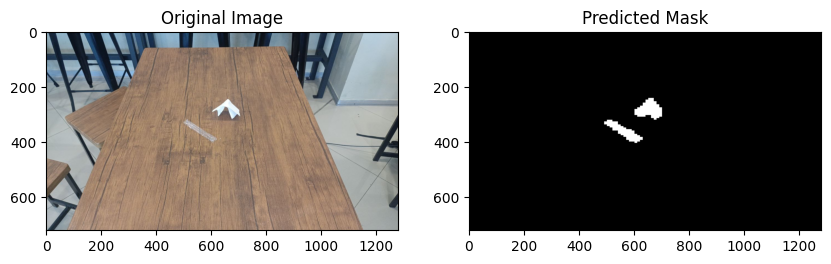

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title("Original Image")

plt.subplot(1,2,2)
plt.imshow(mask_resized, cmap="gray")
plt.title("Predicted Mask")
plt.show()

### Save the Mask Result

In [ ]:
# convert ke uint8 & scale 0–255
mask_save = (mask_resized * 255).astype("uint8")

save_path = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/test_masks/sampah_CIT_seg.png"

cv2.imwrite(save_path, mask_save)

True

## DPT (Dense Prediction Transformer)
Pada eksperimen ini, kami menggunakan DPT-Large (Dense Prediction Transformer) yang telah pretrained pada dataset ADE20K untuk tugas semantic segmentation. DPT menggunakan transformer backbone untuk menangkap konteks global pada gambar, memungkinkan prediksi kelas untuk setiap piksel. Varian ini memiliki paramater berjumlah sekitar 343 juta parameter.

Model ini kami ambil dari HuggingFace: https://huggingface.co/Intel/dpt-large-ade

![image.png](markdown_image/DPT.jpg)

### Import Libraries

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import DPTForSemanticSegmentation, DPTImageProcessor
from google.colab import drive
import matplotlib.pyplot as plt

### Cuda (GPU) Initialization

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Mount Google Drive & Access Dataset

In [ ]:
drive.mount('/content/drive')

# Path dataset
image_dir = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/images_aug"
mask_dir  = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/masks_aug"

### Custom Dataset for Trash Segmentation

In [ ]:
class TrashDataset(Dataset):
    def __init__(self, image_list, mask_list, image_dir, mask_dir, processor):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.processor = processor
        self.images = image_list
        self.masks  = mask_list

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # load image
        image = Image.open(os.path.join(self.image_dir, self.images[idx])).convert("RGB")

        # load mask
        mask = Image.open(os.path.join(self.mask_dir, self.masks[idx]))
        mask = np.array(mask)
        mask = (mask > 0).astype(np.int64)  # labels: sampah=1, background=0

        # encoding image dan label (Processor menangani resizing dan alignment)
        encoded = self.processor(
            images=image,
            segmentation_maps=mask,
            return_tensors="pt"
        )

        # squeeze untuk hilangkan batch (nanti akan diterapkan pada data loader)
        pixel_values = encoded["pixel_values"].squeeze(0)
        labels = encoded["labels"].squeeze(0)

        return {"pixel_values": pixel_values, "labels": labels}


### Train Test Split

In [ ]:
# Train / Validation (test) split
all_images = sorted(os.listdir(image_dir))
all_masks  = sorted(os.listdir(mask_dir))

train_images, val_images, train_masks, val_masks = train_test_split(
    all_images, all_masks, test_size=0.2, random_state=42
)

### Load Processor and Model

In [ ]:
processor = DPTImageProcessor.from_pretrained("Intel/dpt-large-ade")
model = DPTForSemanticSegmentation.from_pretrained(
    "Intel/dpt-large-ade",
    num_labels=2,
    ignore_mismatched_sizes=True
)

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

Some weights of DPTForSemanticSegmentation were not initialized from the model checkpoint at Intel/dpt-large-ade and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.batch_norm1.bias', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm1.num_batches_tracked', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm1.running_mean', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm1.running_var', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm1.weight', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm2.bias', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm2.num_batches_tracked', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm2.running_mean', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm2.running_var', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm2.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this mo

### Create Data Loader

In [ ]:
train_dataset = TrashDataset(train_images, train_masks, image_dir, mask_dir, processor)
val_dataset   = TrashDataset(val_images, val_masks, image_dir, mask_dir, processor)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)

### Loss Criterion

#### DiceLoss
Gunakan DiceLoss karena kita ingin mensegmentasi sampah yang cenderung memiliki area lebih kecil dibandingkan background. 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth    # biar hasilnya ga NaN

    def forward(self, logits, targets):
        B, C, H, W = logits.shape

        # Convert to one-hot
        targets_one_hot = F.one_hot(targets, num_classes=C).permute(0, 3, 1, 2).float()

        # Softmax → probabilities
        probs = torch.softmax(logits, dim=1)

        # Flatten
        probs = probs.view(B, C, -1)
        targets_one_hot = targets_one_hot.view(B, C, -1)

        # Intersection & union
        intersection = (probs * targets_one_hot).sum(dim=2)
        union = probs.sum(dim=2) + targets_one_hot.sum(dim=2)

        dice_score = (2 * intersection + self.smooth) / (union + self.smooth)

        # Hanya foreground = kelas 1 (sampah) yang dihitung
        dice_loss = 1 - dice_score[:, 1]  # kelas 1 = foreground

        return dice_loss.mean()


#### Gabungkan DiceLoss dengan Cross Entropy

In [ ]:
# Tentukan Bobot
class_weights_cel = torch.tensor([0.05, 0.95]).to(device) # 0.05 untuk background, 0.95 untuk sampah

# Definisikan komponen Loss
cel_criterion = nn.CrossEntropyLoss(weight=class_weights_cel)
dice_criterion = DiceLoss()

# Tentukan bobot loss
ALPHA = 0.3  # CE 30%, Dice 70%

def hybrid_loss_criterion(logits_upsampled, labels):
    loss_cel = cel_criterion(logits_upsampled, labels)
    loss_dice = dice_criterion(logits_upsampled, labels)

    return (ALPHA * loss_cel) + ((1 - ALPHA) * loss_dice)   # total loss

### Load Optimizer

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

### Evaluation Matrix per Epoch (IoU)
$\text{IoU}_{c} = \frac{|P_c \cap G_c|}{|P_c \cup G_c|}$

In [ ]:
def calculate_iou_per_class(predictions, labels, num_classes):
    # Ubah tensor menjadi 1D agar mudah dihitung
    preds = predictions.flatten()
    lbls  = labels.flatten()

    iou_per_class = []

    for cls in range(num_classes):
        # bandingkan hasil prediksi dengan ground truth
        pred_mask  = (preds == cls)
        label_mask = (lbls == cls)

        # Hitung intersection dan union
        intersection = (pred_mask & label_mask).sum()
        union        = (pred_mask | label_mask).sum()

        if union == 0:
            iou_per_class.append(np.nan)
        else:
            iou_per_class.append(intersection / union)

    return np.array(iou_per_class)

### Model Evaluation (Before Training)

In [ ]:
model.to(device)
model.eval()

running_val_loss = 0.0
val_miou_scores = []
val_iou_objek_scores = []
num_classes = 2

with torch.no_grad():
    for batch in val_loader:
        # Ambil input validasi
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass validasi
        outputs = model(pixel_values=pixel_values)
        logits = outputs.logits

        # Sesuaikan dimensi label
        logits_upsampled = F.interpolate(
            logits,
            size=labels.shape[1:],
            mode='bilinear',
            align_corners=False
        )

        # Hitung loss
        loss = hybrid_loss_criterion(logits_upsampled, labels)
        running_val_loss += loss.item()

        # Prediksi mask
        predicted_masks = logits_upsampled.argmax(dim=1)

        # IoU per kelas
        iou_per_class = calculate_iou_per_class(
            predicted_masks.cpu().numpy(),
            labels.cpu().numpy(),
            num_classes
        )

        # Ambil IoU kelas 1 (objek), kelas 0 (background)
        iou_bg = iou_per_class[0]
        iou_objek = iou_per_class[1]

        # Simpan mIoU batch ini
        val_miou_scores.append(np.nanmean(iou_per_class))

        # Simpan IoU objek
        val_iou_objek_scores.append(iou_objek)

avg_val_loss = running_val_loss / len(val_loader)
avg_val_miou = np.nanmean(val_miou_scores)
avg_val_iou_objek = np.nanmean(val_iou_objek_scores)
print(f"Val mIoU: {avg_val_miou:.4f} | IoU OBJEK: {avg_val_iou_objek:.4f}")

Val mIoU: 0.0397 | IoU OBJEK: 0.0498


### Training

In [ ]:
model.to(device)
num_epochs = 20
num_classes = 2
save_dir = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/DPT_model"
best_val_iou = 0.0
best_model_path = None

os.makedirs(save_dir, exist_ok=True)

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for batch in tqdm(train_loader):
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(pixel_values=pixel_values)
        logits = outputs.logits

        logits_upsampled = F.interpolate(
            logits,
            size=labels.shape[1:],
            mode='bilinear',
            align_corners=False
        )

        loss = hybrid_loss_criterion(logits_upsampled, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)

    # Validasi
    model.eval()
    running_val_loss = 0.0
    val_miou_scores = []
    val_iou_objek_scores = []

    with torch.no_grad():
        for batch in val_loader:

            # Ambil input validasi
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass validasi
            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits

            # Upsample agar match dimensi label
            logits_upsampled = F.interpolate(
                logits,
                size=labels.shape[1:],
                mode='bilinear',
                align_corners=False
            )

            # Hitung hybrid loss
            loss = hybrid_loss_criterion(logits_upsampled, labels)
            running_val_loss += loss.item()

            # Prediksi mask
            predicted_masks = logits_upsampled.argmax(dim=1)

            # IoU per kelas
            iou_per_class = calculate_iou_per_class(
                predicted_masks.cpu().numpy(),
                labels.cpu().numpy(),
                num_classes
            )

            # Ambil IoU kelas 1 (objek), kelas 0 (background)
            iou_bg = iou_per_class[0]
            iou_objek = iou_per_class[1]

            # Simpan mIoU batch ini
            val_miou_scores.append(np.nanmean(iou_per_class))

            # Simpan IoU objek
            val_iou_objek_scores.append(iou_objek)

    avg_val_loss = running_val_loss / len(val_loader)
    avg_val_miou = np.nanmean(val_miou_scores)
    avg_val_iou_objek = np.nanmean(val_iou_objek_scores)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val mIoU: {avg_val_miou:.4f} | IoU OBJEK: {avg_val_iou_objek:.4f}")

    # Simpan hanya jika IoU meningkat
    if avg_val_iou_objek > best_val_iou:

        # Hapus model lama kalau ada
        if best_model_path is not None and os.path.exists(best_model_path):
            os.remove(best_model_path)
            print(f"🗑️ Model lama dihapus: {best_model_path}")

        best_val_iou = avg_val_iou_objek

        # Simpan model baru
        checkpoint = {
            "epoch": epoch + 1,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict()
        }

        best_model_path = os.path.join(save_dir, "best_model.pth")
        torch.save(checkpoint, best_model_path)

        print(f"💾 Model baru disimpan: {best_model_path}")

    else:
        print("❌ IoU tidak meningkat → model tidak disimpan & tidak ada file baru.")

100%|██████████| 1440/1440 [1:13:07<00:00,  3.05s/it]


Epoch 1/20 - Train Loss: 0.4201 | Val Loss: 0.3808 | Val mIoU: 0.7707 | IoU OBJEK: 0.5660
💾 Model baru disimpan: /content/drive/MyDrive/Colab Notebooks/Computer Vision/DPT_model/best_model.pth


100%|██████████| 1440/1440 [1:15:36<00:00,  3.15s/it]


Epoch 2/20 - Train Loss: 0.3316 | Val Loss: 0.3262 | Val mIoU: 0.7818 | IoU OBJEK: 0.5908
🗑️ Model lama dihapus: /content/drive/MyDrive/Colab Notebooks/Computer Vision/DPT_model/best_model.pth
💾 Model baru disimpan: /content/drive/MyDrive/Colab Notebooks/Computer Vision/DPT_model/best_model.pth


  0%|          | 4/1440 [00:14<1:26:00,  3.59s/it]


KeyboardInterrupt: 

### Additional DPT Training Results and IoU Evaluation
Dikarenakan training model DPT dilakukan secara terpotong-potong, proses pelatihan tidak berjalan dalam satu siklus penuh secara kontinu.

Berikut hasil evaluasi training tiap epoch:
1. Train Loss: 0.4201 | Val Loss: 0.3808 | Val mIoU: 0.7707 | IoU OBJEK: 0.5660 
2. Train Loss: 0.3316 | Val Loss: 0.3262 | Val mIoU: 0.7818 | IoU OBJEK: 0.5908 
3. Train Loss: 0.3122 | Val Loss: 0.3522 | Val mIoU: 0.8029 | IoU OBJEK: 0.6253 
4. Train Loss: 0.2701 | Val Loss: 0.3150 | Val mIoU: 0.8018 | IoU OBJEK: 0.6241 
5. Train Loss: 0.2391 | Val Loss: 0.2987 | Val mIoU: 0.8079 | IoU OBJEK: 0.6357 
6. Train Loss: 0.1492 | Val Loss: 0.3461 | Val mIoU: 0.7960 | IoU OBJEK: 0.6129 
7. Train Loss: 0.2250 | Val Loss: 0.2374 | Val mIoU: 0.8241 | IoU OBJEK: 0.6691 
8. Train Loss: 0.2002 | Val Loss: 0.2274 | Val mIoU: 0.8331 | IoU OBJEK: 0.6847 
9. Train Loss: 0.1843 | Val Loss: 0.2214 | Val mIoU: 0.8322 | IoU OBJEK: 0.6840 
10. Train Loss: 0.1837 | Val Loss: 0.2206 | Val mIoU: 0.8369 | IoU OBJEK: 0.6919 
11. Train Loss: 0.1671 | Val Loss: 0.2136 | Val mIoU: 0.8445 | IoU OBJEK: 0.7055
12. Train Loss: 0.1548 | Val Loss: 0.2087 | Val mIoU: 0.8469 | IoU OBJEK: 0.7101
13. Train Loss: 0.1283 | Val Loss: 0.1992 | Val mIoU: 0.8569 | IoU OBJEK: 0.7274
14. Train Loss: 0.1109 | Val Loss: 0.1995 | Val mIoU: 0.8543 | IoU OBJEK: 0.7211
15. Train Loss: 0.1217 | Val Loss: 0.1976 | Val mIoU: 0.8622 | IoU OBJEK: 0.7376
16. Train Loss: 0.1114 | Val Loss: 0.1985 | Val mIoU: 0.8538 | IoU OBJEK: 0.7204
17. Train Loss: 0.1114 | Val Loss: 0.1985 | Val mIoU: 0.8545 | IoU OBJEK: 0.7213
18. Train Loss: 0.1153 | Val Loss: 0.1988 | Val mIoU: 0.8678 | IoU OBJEK: 0.7476
19. Train Loss: 0.1105 | Val Loss: 0.1952 | Val mIoU: 0.8679 | IoU OBJEK: 0.7480
20. Train Loss: 0.1054 | Val Loss: 0.1916 | Val mIoU: 0.8676 | IoU OBJEK: 0.7475

In [ ]:
model.to(device)
num_epochs = 20
num_classes = 2
save_dir = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/DPT_model"
best_val_iou = 0.0
best_model_path = None

os.makedirs(save_dir, exist_ok=True)

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for batch in tqdm(train_loader):
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(pixel_values=pixel_values)
        logits = outputs.logits

        logits_upsampled = F.interpolate(
            logits,
            size=labels.shape[1:],
            mode='bilinear',
            align_corners=False
        )

        loss = hybrid_loss_criterion(logits_upsampled, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)

    # Validasi
    model.eval()
    running_val_loss = 0.0
    val_miou_scores = []
    val_iou_objek_scores = []

    with torch.no_grad():
        for batch in val_loader:

            # Ambil input validasi
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass validasi
            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits

            # Upsample agar match dimensi label
            logits_upsampled = F.interpolate(
                logits,
                size=labels.shape[1:],
                mode='bilinear',
                align_corners=False
            )

            # Hitung hybrid loss
            loss = hybrid_loss_criterion(logits_upsampled, labels)
            running_val_loss += loss.item()

            # Prediksi mask
            predicted_masks = logits_upsampled.argmax(dim=1)

            # IoU per kelas
            iou_per_class = calculate_iou_per_class(
                predicted_masks.cpu().numpy(),
                labels.cpu().numpy(),
                num_classes
            )

            # Ambil IoU kelas 1 (objek), kelas 0 (background)
            iou_bg = iou_per_class[0]
            iou_objek = iou_per_class[1]

            # Simpan mIoU batch ini
            val_miou_scores.append(np.nanmean(iou_per_class))

            # Simpan IoU objek
            val_iou_objek_scores.append(iou_objek)

    avg_val_loss = running_val_loss / len(val_loader)
    avg_val_miou = np.nanmean(val_miou_scores)
    avg_val_iou_objek = np.nanmean(val_iou_objek_scores)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val mIoU: {avg_val_miou:.4f} | IoU OBJEK: {avg_val_iou_objek:.4f}")

    # Simpan hanya jika IoU meningkat
    if avg_val_iou_objek > best_val_iou:

        # Hapus model lama kalau ada
        if best_model_path is not None and os.path.exists(best_model_path):
            os.remove(best_model_path)
            print(f"🗑️ Model lama dihapus: {best_model_path}")

        best_val_iou = avg_val_iou_objek

        # Simpan model baru
        checkpoint = {
            "epoch": epoch + 1,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict()
        }

        best_model_path = os.path.join(save_dir, "best_model.pth")
        torch.save(checkpoint, best_model_path)

        print(f"💾 Model baru disimpan: {best_model_path}")

    else:
        print("❌ IoU tidak meningkat → model tidak disimpan & tidak ada file baru.")

100%|██████████| 1440/1440 [1:12:40<00:00,  3.03s/it]


Epoch 1/20 - Train Loss: 0.1054 | Val Loss: 0.1916 | Val mIoU: 0.8676 | IoU OBJEK: 0.7475


KeyboardInterrupt: 

### Load Best Model
Berdasarkan nilai IoU objek (sampah), nilai terbaik pada proses training adalah 0.7480

In [ ]:
# Config path
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/DPT_model/best_model.pth"

# Inisialisasi Model (Sama seperti saat training)
processor = DPTImageProcessor.from_pretrained("Intel/dpt-large-ade")
model = DPTForSemanticSegmentation.from_pretrained(
    "Intel/dpt-large-ade",
    num_labels=2,
    ignore_mismatched_sizes=True
)

# Muat Checkpoint Dictionary
ckpt = torch.load(checkpoint_path, map_location="cpu")

# Ambil model_state dari checkpoint dan muat bobotnya
model.load_state_dict(ckpt["model_state"])

print(f"Model dari {checkpoint_path} berhasil dimuat dan siap untuk evaluasi.")

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

Some weights of DPTForSemanticSegmentation were not initialized from the model checkpoint at Intel/dpt-large-ade and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.batch_norm1.bias', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm1.num_batches_tracked', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm1.running_mean', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm1.running_var', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm1.weight', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm2.bias', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm2.num_batches_tracked', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm2.running_mean', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm2.running_var', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm2.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this mo

model.safetensors:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

Model dari /content/drive/MyDrive/Colab Notebooks/Computer Vision/DPT_model/best_model.pth berhasil dimuat dan siap untuk evaluasi.


### Model Evaluation (IoU)

In [ ]:
model.to(device)
model.eval()

running_val_loss = 0.0
val_miou_scores = []
val_iou_objek_scores = []
num_classes = 2

with torch.no_grad():
    for batch in val_loader:
        # Ambil input validasi
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass validasi
        outputs = model(pixel_values=pixel_values)
        logits = outputs.logits

        # Upsample agar match dimensi label
        logits_upsampled = F.interpolate(
            logits,
            size=labels.shape[1:],
            mode='bilinear',
            align_corners=False
        )

        # Hitung loss
        loss = hybrid_loss_criterion(logits_upsampled, labels)
        running_val_loss += loss.item()

        # Prediksi mask
        predicted_masks = logits_upsampled.argmax(dim=1)

        # Hitung IoU per kelas
        iou_per_class = calculate_iou_per_class(
            predicted_masks.cpu().numpy(),
            labels.cpu().numpy(),
            num_classes
        )

        # Ambil IoU kelas 1 (objek), kelas 0 (background)
        iou_bg = iou_per_class[0]
        iou_objek = iou_per_class[1]

        # Simpan mIoU batch
        val_miou_scores.append(np.nanmean(iou_per_class))

        # Simpan IoU objek
        val_iou_objek_scores.append(iou_objek)

avg_val_loss = running_val_loss / len(val_loader)
avg_val_miou = np.nanmean(val_miou_scores)
avg_val_iou_objek = np.nanmean(val_iou_objek_scores)
print(f"Val mIoU: {avg_val_miou:.4f} | IoU OBJEK: {avg_val_iou_objek:.4f}")

Val mIoU: 0.8679 | IoU OBJEK: 0.7480


### Inference

In [ ]:
image_path = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/test_images/sampah CIT.jpg"
image = Image.open(image_path).convert("RGB")

In [ ]:
encoding = processor(images=image, return_tensors="pt")
pixel_values = encoding["pixel_values"].to(device)  # shape: (1, 3, H, W)

with torch.no_grad():
    outputs = model(pixel_values=pixel_values)
    logits = outputs.logits  # (1, num_classes, H, W)
    preds = logits.argmax(dim=1)  # (1, H, W) -> class per pixel

mask = preds.squeeze(0).cpu().numpy()  # (H, W)

# Konversi mask ke uint8
mask_uint8 = mask.astype(np.uint8)

# Resize mask agar sesuai gambar asli
mask_resized = cv2.resize(mask_uint8, image.size, interpolation=cv2.INTER_NEAREST)

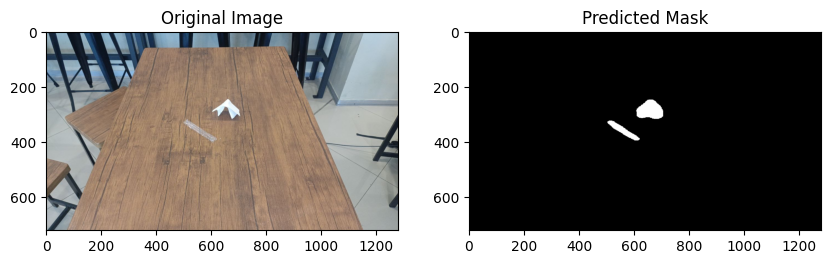

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title("Original Image")

plt.subplot(1,2,2)
plt.imshow(mask_resized, cmap="gray")
plt.title("Predicted Mask")
plt.show()

### Save the Mask Result

In [ ]:
# convert ke uint8 & scale 0–255
mask_save = (mask_resized * 255).astype("uint8")

save_path = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/test_masks/sampah_CIT_dpt.png"

cv2.imwrite(save_path, mask_save)

True

## Discriminative Model Evaluation

Perbandingan mIoU dan IoU sampah tiap model: 

| Model     | Training Phase   | mIoU   | IoU Sampah     |
|-----------|------------------|--------|----------------|
| SegFormer | Before training  | 0.2954 | 0.0331         |
| SegFormer | After training   | 0.8761 | 0.7659         |
| DPT       | Before training  | 0.0397 | 0.0498         |
| DPT       | After training   | 0.8679 | 0.7480         |

Berdasarkan hasil evaluasi, baik SegFormer maupun DPT mengalami peningkatan performa yang signifikan setelah proses training. Namun, SegFormer menunjukkan hasil yang sedikit lebih unggul dengan mIoU sebesar 0.8761 dan IoU Sampah sebesar 0.7659 dibandingkan DPT. Selain memberikan performa segmentasi yang kompetitif, SegFormer juga lebih direkomendasikan untuk tugas segmentasi sampah karena memiliki arsitektur yang lebih ringan, sehingga proses training berlangsung lebih cepat. Keunggulan ini menjadikan SegFormer lebih sesuai untuk aplikasi segmentasi sampah yang membutuhkan kecepatan dan efisiensi komputasi tanpa mengorbankan akurasi secara signifikan.

# Generatif
Pada tahap generatif, kami membandingkan dua model: Stable Diffusion dan ControlNet untuk proses menghapus sampah. Kedua model ini dipilih karena dapat melakukan inpainting sesuai dengan image asli, mask, dan text prompt.

## Stable Diffusion
Stable Diffusion Inpainting adalah model difusi laten berbasis teks-ke-gambar yang mampu menghasilkan citra foto-realistis berdasarkan masukan teks apa pun, dengan kemampuan tambahan untuk melakukan inpainting pada gambar menggunakan sebuah mask. Pada proyek ini, kami menggunakan model Stable Diffusion inpainting untuk menghilangkan gambar sampah yang sebelumnya telah ditutup oleh mask hasil segmentasi. Model ini memiliki jumlah parameter sekitar 1 miliar parameter.


Model ini kami ambil dari HuggingFace: https://huggingface.co/stable-diffusion-v1-5/stable-diffusion-inpainting

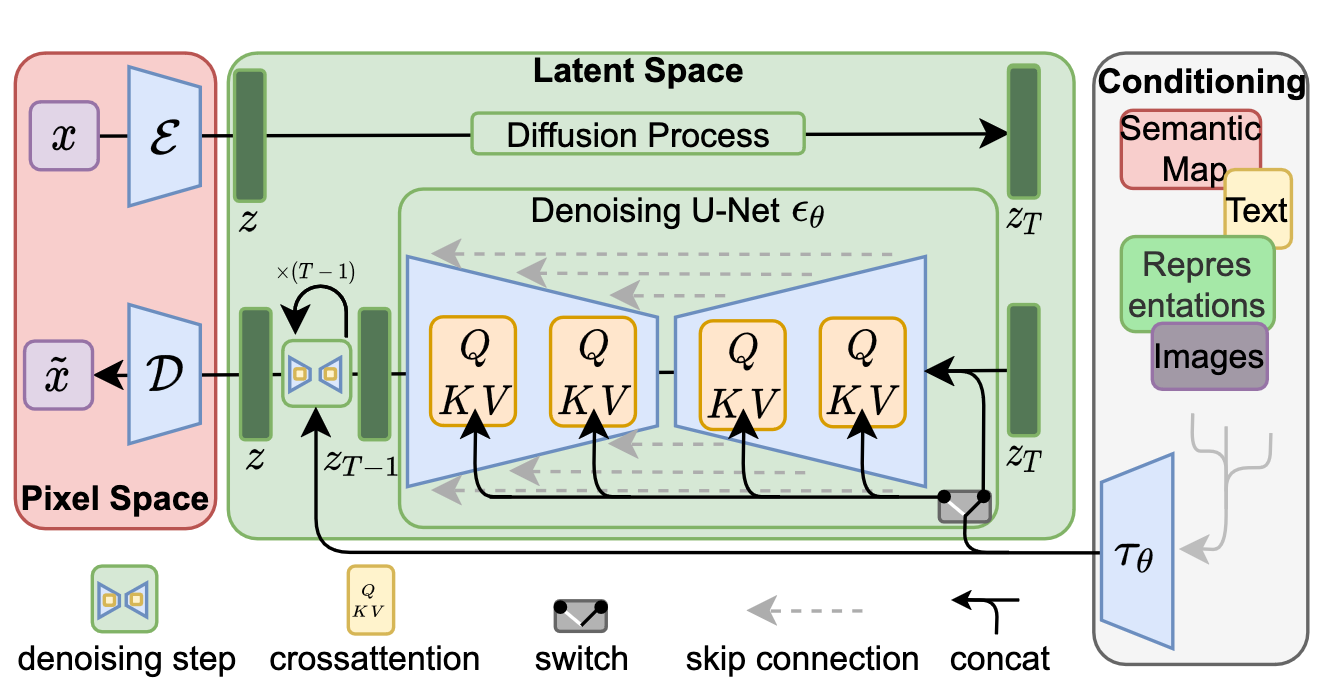

### Import Libraries

In [ ]:
!pip install -U -q diffusers transformers accelerate peft huggingface-hub
!pip install -q bitsandbytes safetensors pillow xformers scikit-image lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 758.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 151.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
from google.colab import drive
drive.mount('/content/mydrive')

# Setup Hugging Face authentication
try:
    from google.colab import userdata
    from huggingface_hub import login

    hf_token = userdata.get('HF_TOKEN')
    login(token=hf_token)
    print("Logged in to Hugging Face successfully!")
except Exception as e:
    print(f"HF Token not found: {e}")

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from diffusers import StableDiffusionInpaintPipeline, AutoencoderKL, UNet2DConditionModel, DDPMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from peft import LoraConfig, get_peft_model, PeftModel
from PIL import Image
import os
from pathlib import Path
from tqdm import tqdm
import numpy as np
from accelerate import Accelerator
import lpips

Mounted at /content/mydrive
Logged in to Hugging Face successfully!
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


### Cuda (GPU) Initialization

In [ ]:
# Check GPU
if torch.cuda.is_available():
    print(f"GPU Available: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("WARNING: No GPU detected!")

GPU Available: Tesla T4
GPU Memory: 15.83 GB


### Define Training Config

In [ ]:
class TrainingConfig:
    # Paths
    dataset_dir = "/content/mydrive/MyDrive/Colab Notebooks/Computer Vision"
    images_dir = f"{dataset_dir}/images"      # Dirty images (with trash)
    masks_dir = f"{dataset_dir}/masks"        # Mask trash area
    clean_images_dir = f"{dataset_dir}/clean" # Clean images (ground truth)
    output_dir = "/content/mydrive/MyDrive/Colab Notebooks/Computer Vision/lora_trash_inpainting"
    test_image_dir = "/content/mydrive/MyDrive/Colab Notebooks/Computer Vision/test_images"
    test_mask_dir = "/content/mydrive/MyDrive/Colab Notebooks/Computer Vision/test_masks"

    # Model
    base_model = "stable-diffusion-v1-5/stable-diffusion-inpainting"

    # LoRA settings
    lora_rank = 16
    lora_alpha = 32
    lora_dropout = 0.1

    # Training settings
    batch_size = 4
    num_epochs = 5
    learning_rate = 1e-4
    gradient_accumulation_steps = 8
    mixed_precision = "fp16"
    gradient_checkpointing = True

    # Image settings
    resolution = 512

    # Dataset split
    train_split = 0.95
    max_train_samples = None    # None = full dataset

    # Checkpointing
    save_steps = 200
    validation_steps = 100

    # Memory optimization
    enable_xformers = True  # hitung tanpa simpan full attention matrix
    dataloader_num_workers = 2

    # Prompts
    train_prompt = "clean background, clean environment, asphalt road, grass, rock, leaf"
    negative_prompt = "trash, rubish, garbage, litter, plastic bottle, bottle, can, plastic, paper, waste, debris"

    # Resume settings (untuk melanjutkan proses training)
    resume_from_checkpoint = None
    start_epoch = 0

config = TrainingConfig()

### Custom Dataset for Trash Inpainting

In [ ]:
class TrashInpaintingDataset(Dataset):
    def __init__(self, images_dir, masks_dir, clean_images_dir, tokenizer, resolution=512, max_samples=None):
        self.images_dir = Path(images_dir)
        self.masks_dir = Path(masks_dir)
        self.clean_images_dir = Path(clean_images_dir)
        self.tokenizer = tokenizer  # Tokenizer CLIP
        self.resolution = resolution

        # Ambil semua image
        self.image_files = sorted([f for f in os.listdir(images_dir)
                                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

        # Mengambil gambar sesuai limit pada config
        if max_samples:
            self.image_files = self.image_files[:max_samples]

        print(f"Dataset initialized with {len(self.image_files)} images")
        print(f"  - Dirty images: {images_dir}")
        print(f"  - Masks: {masks_dir}")
        print(f"  - Clean images: {clean_images_dir}")

    def __len__(self):
        return len(self.image_files)

    def preprocess_image(self, image):
        # resize ke 512 x 512 sesuai input stable diffusion 
        image = image.resize((self.resolution, self.resolution), Image.LANCZOS)
        image = np.array(image).astype(np.float32) / 127.5 - 1.0
        image = torch.from_numpy(image).permute(2, 0, 1)
        return image

    def preprocess_mask(self, mask):
        # resize ke 512 x 512 dan pastikan masking biner
        mask = mask.resize((self.resolution, self.resolution), Image.LANCZOS)
        mask = np.array(mask).astype(np.float32) / 255.0
        mask = torch.from_numpy(mask).unsqueeze(0)
        return mask

    def __getitem__(self, idx):
        # buat path untuk masing-masing gambar
        img_name = self.image_files[idx]
        dirty_image_path = self.images_dir / img_name
        mask_path = self.masks_dir / img_name
        clean_image_path = self.clean_images_dir / img_name

        try:
            # Load semua image
            dirty_image = Image.open(dirty_image_path).convert("RGB")
            mask = Image.open(mask_path).convert("L")
            clean_image = Image.open(clean_image_path).convert("RGB")

            # Preprocess
            dirty_image = self.preprocess_image(dirty_image)
            mask = self.preprocess_mask(mask)
            clean_image = self.preprocess_image(clean_image)

            # Tokenize prompt
            text_inputs = self.tokenizer(
                config.train_prompt,
                padding="max_length",
                max_length=self.tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt"
            )

            return {
                "pixel_values": dirty_image,       # Input: image yang ada sampahnya
                "mask": mask,                      # Mask: area sampah (putih dengan background hitam)
                "clean_values": clean_image,       # Ground truth: image yang sudah dibersihkan sampahnya
                "input_ids": text_inputs.input_ids[0],
                "filename": img_name
            }
        except Exception as e:
            print(f"Error loading {img_name}: {e}")
            return self.__getitem__((idx + 1) % len(self))

### Checkpoint Detection for Resume Training

In [ ]:
checkpoint_dir = config.output_dir

if os.path.exists(checkpoint_dir):
    # Ambil dan sort semua checkpoint
    checkpoints = [d for d in os.listdir(checkpoint_dir) if d.startswith('checkpoint-')]
    checkpoints.sort(key=lambda x: int(x.split('-')[1]))

    if checkpoints:
        print(f"Found {len(checkpoints)} checkpoints:")
        for cp in checkpoints:
            print(f"  - {cp}")

        # ambil checkpoint terakhir
        latest_checkpoint = checkpoints[-1]
        print(f"\nLatest checkpoint: {latest_checkpoint}")
        
        latest_step = int(latest_checkpoint.split('-')[1])
        print(f"Training stopped at step: {latest_step}")

        # Auto-set resume
        config.resume_from_checkpoint = f"{checkpoint_dir}/{latest_checkpoint}"
        steps_per_epoch = 2398 // config.batch_size
        config.start_epoch = latest_step // steps_per_epoch
        print(f"Will resume from epoch ~{config.start_epoch}")
    else:
        print("No checkpoints found. Starting fresh training.")
        config.resume_from_checkpoint = None
        config.start_epoch = 0
else:
    print(f"Checkpoint directory not found.")
    print("Starting training from scratch.")
    config.resume_from_checkpoint = None
    config.start_epoch = 0

if os.path.exists(f"{checkpoint_dir}/best_model"):
    print("\nBest model checkpoint also available.")

Checkpoint directory not found.
Starting training from scratch.


### Model Evaluation Matrix: LPIPS (Learned Perceptual Image Patch Similarity)

![Foto 1](markdown_image/LPIPS.png)

In [ ]:
# Inisialisasi model LPIPS
lpips_model = None

def get_lpips_model():
    """Inisialisasi model LPIPS model (AlexNet)"""
    global lpips_model
    if lpips_model is None:
        print("Loading LPIPS model (AlexNet)...")
        lpips_model = lpips.LPIPS(net='alex').cuda()
        lpips_model.eval()
        print("LPIPS model loaded")
    return lpips_model

def calculate_lpips(img1, img2):
    """Hitung LPIPS score (semakin kecil semakin bagus)"""
    model = get_lpips_model()

    # Pastikan tensor ada dalam GPU dan memiliki dimensi batch (format harus B, C, H, W)
    if img1.dim() == 3:
        img1 = img1.unsqueeze(0)
    if img2.dim() == 3:
        img2 = img2.unsqueeze(0)

    img1 = img1.cuda()
    img2 = img2.cuda()

    with torch.no_grad():
        lpips_score = model(img1, img2)

    return lpips_score.item()

def evaluate_batch_lpips(predicted_images, target_images):
    """ Evaluasi LPIPS pada batch """
    batch_size = predicted_images.shape[0]
    lpips_scores = []

    for i in range(batch_size):
        score = calculate_lpips(predicted_images[i], target_images[i])
        lpips_scores.append(score)

    return {
        'lpips': np.mean(lpips_scores),
        'lpips_std': np.std(lpips_scores)
    }

def validate_with_lpips(unet, val_dataloader, vae, text_encoder, noise_scheduler, accelerator, calculate_lpips_metric=True):
    """ Validasi LPIPS menggunakan ground truth (image yang sudah di blur sampahnya menggunakan YOLO)"""
    unet.eval()
    val_loss = 0
    all_lpips = []

    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    np.random.seed(42)

    with torch.no_grad():
        for batch_idx, batch in enumerate(val_dataloader):
            # Encode ground truth (image bersih) ke latent
            clean_latents = vae.encode(batch["clean_values"].to(dtype=torch.float16)).latent_dist.sample()
            clean_latents = clean_latents * vae.config.scaling_factor

            # Tambahin noise di seluruh latent gambar
            noise = torch.randn_like(clean_latents)
            bsz = clean_latents.shape[0]
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bsz,),
                device=clean_latents.device
            ).long()
            noisy_latents = noise_scheduler.add_noise(clean_latents, noise, timesteps)

            # resize mask ke dimensi latent space
            mask = F.interpolate(
                batch["mask"].to(dtype=torch.float16),
                size=(clean_latents.shape[2], clean_latents.shape[3]),
                mode='nearest'
            )

            # Encode dirty image (image yang ada sampahnya)
            dirty_latents = vae.encode(batch["pixel_values"].to(dtype=torch.float16)).latent_dist.sample()
            dirty_latents = dirty_latents * vae.config.scaling_factor

            # Masking di latent space
            masked_latents = dirty_latents * (1 - mask)
            latent_model_input = torch.cat([noisy_latents, mask, masked_latents], dim=1)

            encoder_hidden_states = text_encoder(batch["input_ids"])[0]     # ambil input text, encode
            model_pred = unet(latent_model_input, timesteps, encoder_hidden_states).sample

            loss = F.mse_loss(model_pred.float(), noise.float(), reduction="mean")
            val_loss += loss.item()

            # Hitung LPIPS
            if calculate_lpips_metric:
                predicted_latents = clean_latents + (model_pred - noise)
                predicted_latents = predicted_latents.to(dtype=torch.float16)
                predicted_images = vae.decode(predicted_latents / vae.config.scaling_factor).sample
                target_images = batch["clean_values"]

                batch_lpips = evaluate_batch_lpips(predicted_images, target_images)
                all_lpips.append(batch_lpips['lpips'])

    result = {'val_loss': val_loss / len(val_dataloader)}
    if all_lpips:
        result['lpips'] = np.mean(all_lpips)

    return result

### Training Function (with LoRA)

In [ ]:
def train_lora_inpainting_with_lpips():
    # otomatisasi backward, handle GPU, dll.
    accelerator = Accelerator(
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        mixed_precision=config.mixed_precision
    )

    torch.cuda.empty_cache()

    tokenizer = CLIPTokenizer.from_pretrained(config.base_model, subfolder="tokenizer")
    text_encoder = CLIPTextModel.from_pretrained(config.base_model, subfolder="text_encoder", torch_dtype=torch.float16)
    vae = AutoencoderKL.from_pretrained(config.base_model, subfolder="vae", torch_dtype=torch.float16)
    unet = UNet2DConditionModel.from_pretrained(config.base_model, subfolder="unet", torch_dtype=torch.float16)
    noise_scheduler = DDPMScheduler.from_pretrained(config.base_model, subfolder="scheduler")

    print("\nBase model loaded!")

    # optimisasi memory
    if config.gradient_checkpointing:
        unet.enable_gradient_checkpointing()
        print("Gradient checkpointing enabled")

    if config.enable_xformers:
        try:
            unet.enable_xformers_memory_efficient_attention()
            print("xFormers enabled")
        except:
            print("xFormers not available")

    # Freeze VAE dan text encoder
    vae.requires_grad_(False)
    text_encoder.requires_grad_(False)

    # Load LoRA dari checkpoint atau inisialiasai LoRA
    if config.resume_from_checkpoint:
        print(f"\nLoading from: {config.resume_from_checkpoint}")

        try:
            unet = PeftModel.from_pretrained(unet, config.resume_from_checkpoint, is_trainable=True)
            print("LoRA weights loaded from checkpoint")
        except Exception as e:
            print(f"Error: {e}")
            print("Starting with new LoRA...")
            lora_config = LoraConfig(
                r=config.lora_rank,
                lora_alpha=config.lora_alpha,
                init_lora_weights="gaussian",
                target_modules=["to_k", "to_q", "to_v", "to_out.0"],
                lora_dropout=config.lora_dropout,
            )
            unet = get_peft_model(unet, lora_config)
            config.start_epoch = 0
    else:
        print("\nStarting with new LoRA...")

        lora_config = LoraConfig(
            r=config.lora_rank,
            lora_alpha=config.lora_alpha,
            init_lora_weights="gaussian",
            target_modules=["to_k", "to_q", "to_v", "to_out.0"],
            lora_dropout=config.lora_dropout,
        )
        unet = get_peft_model(unet, lora_config)

    unet.print_trainable_parameters()

    # Load dataset
    full_dataset = TrashInpaintingDataset(
        config.images_dir,
        config.masks_dir,
        config.clean_images_dir,
        tokenizer,
        config.resolution,
        config.max_train_samples
    )

    train_size = int(config.train_split * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        full_dataset, [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )

    print(f"\nTraining samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.dataloader_num_workers,
        pin_memory=True
    )

    val_dataloader = DataLoader(
        val_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.dataloader_num_workers,
        pin_memory=True
    )

    # load optimizer (AdamW)
    optimizer = torch.optim.AdamW(
        unet.parameters(),
        lr=config.learning_rate,
        betas=(0.9, 0.999),
        weight_decay=0.01,
        eps=1e-8
    )
    
    # atur learning rate
    num_training_steps = len(train_dataloader) * config.num_epochs
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=num_training_steps,
        eta_min=config.learning_rate * 0.1
    )

    if config.resume_from_checkpoint:
        steps_to_skip = config.start_epoch * len(train_dataloader)
        for _ in range(steps_to_skip):
            lr_scheduler.step()

    unet, optimizer, train_dataloader, val_dataloader, lr_scheduler = accelerator.prepare(
        unet, optimizer, train_dataloader, val_dataloader, lr_scheduler
    )
    vae.to(accelerator.device)
    text_encoder.to(accelerator.device)

    print("\n" + "=" * 60)
    print("STARTING TRAINING")
    print("=" * 60)
    print(f"Starting from epoch: {config.start_epoch + 1}")
    print(f"Total epochs: {config.num_epochs}")
    print(f"Steps per epoch: {len(train_dataloader)}")
    print("=" * 60 + "\n")

    global_step = config.start_epoch * len(train_dataloader)
    best_val_loss = float('inf')
    best_lpips = float('inf')

    for epoch in range(config.start_epoch, config.num_epochs):
        unet.train()
        epoch_loss = 0

        progress_bar = tqdm(
            train_dataloader,
            desc=f"Epoch {epoch+1}/{config.num_epochs}",
            disable=not accelerator.is_local_main_process
        )

        for step, batch in enumerate(progress_bar):
            with accelerator.accumulate(unet):
                # tidak perlu hitung gradien VAE
                with torch.no_grad():
                    clean_latents = vae.encode(batch["clean_values"].to(dtype=torch.float16)).latent_dist.sample()
                    clean_latents = clean_latents * vae.config.scaling_factor

                # generate noise
                noise = torch.randn_like(clean_latents)
                bsz = clean_latents.shape[0]    # batch size

                # variasi noise
                timesteps = torch.randint(
                    0, noise_scheduler.config.num_train_timesteps, (bsz,),
                    device=clean_latents.device
                ).long()

                # tambahkan noise ke latent
                noisy_latents = noise_scheduler.add_noise(clean_latents, noise, timesteps)
                
                # resize mask ke latent space
                mask = F.interpolate(
                    batch["mask"].to(dtype=torch.float16),
                    size=(clean_latents.shape[2], clean_latents.shape[3]),
                    mode='nearest'
                )

                # Embedding dirty image
                with torch.no_grad():
                    dirty_latents = vae.encode(batch["pixel_values"].to(dtype=torch.float16)).latent_dist.sample()
                    dirty_latents = dirty_latents * vae.config.scaling_factor

                # apply mask ke dirty latent
                masked_latents = dirty_latents * (1 - mask)
                latent_model_input = torch.cat([noisy_latents, mask, masked_latents], dim=1)

                # Ambil text embeddings
                with torch.no_grad():
                    encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # prediksi
                model_pred = unet(
                    latent_model_input,
                    timesteps,
                    encoder_hidden_states
                ).sample

                # hitung loss
                loss = F.mse_loss(model_pred.float(), noise.float(), reduction="mean")

                # backprop dengan accelerator
                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(unet.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            epoch_loss += loss.item()
            current_lr = optimizer.param_groups[0]['lr']
            progress_bar.set_postfix({
                "loss": f"{loss.item():.4f}",
                "lr": f"{current_lr:.2e}",
                "step": global_step
            })
            global_step += 1

            # Hitung validasi menggunakan LPIPS
            if global_step % config.validation_steps == 0:
                metrics = validate_with_lpips(unet, val_dataloader, vae, text_encoder, noise_scheduler, accelerator, calculate_lpips_metric=True)

                print(f"\n{'='*60}")
                print(f"Step {global_step} - Validation Metrics:")
                print(f"  Loss: {metrics['val_loss']:.4f}")
                if 'lpips' in metrics:
                    lpips_val = metrics['lpips']
                    print(f"  LPIPS: {lpips_val:.4f}")
                print(f"{'='*60}")

                val_loss = metrics['val_loss']
                current_lpips = metrics.get('lpips', float('inf'))

                # Save best model berdasarkan LPIPS
                if current_lpips < best_lpips:
                    best_lpips = current_lpips
                    best_val_loss = val_loss
                    save_path = f"{config.output_dir}/best_model"
                    os.makedirs(save_path, exist_ok=True)
                    accelerator.unwrap_model(unet).save_pretrained(save_path)
                    print(f"Best model saved! (LPIPS: {current_lpips:.4f}, loss: {val_loss:.4f})")

                unet.train()

            # Save checkpoint
            if global_step % config.save_steps == 0:
                save_path = f"{config.output_dir}/checkpoint-{global_step}"
                os.makedirs(save_path, exist_ok=True)
                accelerator.unwrap_model(unet).save_pretrained(save_path)
                print(f"\nCheckpoint saved at step {global_step}")

            # Clear cache periodically
            if global_step % 100 == 0:
                torch.cuda.empty_cache()

        avg_loss = epoch_loss / len(train_dataloader)
        print(f"\n{'='*60}")
        print(f"Epoch {epoch+1}/{config.num_epochs} Complete")
        print(f"Average Loss: {avg_loss:.4f}")
        print(f"Learning Rate: {current_lr:.2e}")
        print(f"Global Step: {global_step}")
        print(f"{'='*60}\n")

    print("\n" + "=" * 60)
    print("TRAINING COMPLETE!")
    print("=" * 60)
    os.makedirs(config.output_dir, exist_ok=True)
    accelerator.unwrap_model(unet).save_pretrained(config.output_dir)
    print(f"Final model saved to: {config.output_dir}")
    print(f"Best LPIPS: {best_lpips:.4f}")
    print(f"Best validation loss: {best_val_loss:.4f}")
    print("=" * 60)

### Training

In [ ]:
if config.resume_from_checkpoint:
    print(f"Training from previous checkpoint")
    print(f"Starting from epoch: {config.start_epoch + 1}/{config.num_epochs}")
    print()
else:
    print("Starting fresh training")

train_lora_inpainting_with_lpips()

Starting fresh training


tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

text_encoder/pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

An error occurred while trying to fetch stable-diffusion-v1-5/stable-diffusion-inpainting: stable-diffusion-v1-5/stable-diffusion-inpainting does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


vae/diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

An error occurred while trying to fetch stable-diffusion-v1-5/stable-diffusion-inpainting: stable-diffusion-v1-5/stable-diffusion-inpainting does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


unet/diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]


Base model loaded!
Gradient checkpointing enabled
xFormers enabled

Starting with new LoRA...
trainable params: 3,188,736 || all params: 862,724,100 || trainable%: 0.3696
Dataset initialized with 2398 images
  - Dirty images: /content/mydrive/MyDrive/Colab Notebooks/Computer Vision/new_images
  - Masks: /content/mydrive/MyDrive/Colab Notebooks/Computer Vision/new_masks
  - Clean images: /content/mydrive/MyDrive/Colab Notebooks/Computer Vision/new_clean

Training samples: 2278
Validation samples: 120

STARTING TRAINING
Starting from epoch: 1
Total epochs: 5
Steps per epoch: 570



Epoch 1/5:  17%|█▋        | 99/570 [03:47<14:35,  1.86s/it, loss=0.0374, lr=1.00e-04, step=99]

Loading LPIPS model (AlexNet)...
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth



  0%|          | 0.00/233M [00:00<?, ?B/s]
  3%|▎         | 7.75M/233M [00:00<00:02, 81.0MB/s]
 10%|▉         | 22.9M/233M [00:00<00:01, 126MB/s] 
 15%|█▌        | 35.0M/233M [00:00<00:01, 115MB/s]
 23%|██▎       | 53.2M/233M [00:00<00:01, 144MB/s]
 29%|██▉       | 68.8M/233M [00:00<00:01, 150MB/s]
 37%|███▋      | 85.9M/233M [00:00<00:00, 160MB/s]
 43%|████▎     | 101M/233M [00:00<00:01, 131MB/s] 
 49%|████▉     | 115M/233M [00:00<00:00, 133MB/s]
 57%|█████▋    | 133M/233M [00:00<00:00, 148MB/s]
 63%|██████▎   | 148M/233M [00:01<00:00, 146MB/s]
 70%|██████▉   | 162M/233M [00:03<00:03, 20.3MB/s]
 74%|███████▍  | 172M/233M [00:03<00:02, 24.6MB/s]
 78%|███████▊  | 182M/233M [00:03<00:01, 30.0MB/s]
 83%|████████▎ | 193M/233M [00:03<00:01, 38.1MB/s]
 88%|████████▊ | 205M/233M [00:03<00:00, 47.1MB/s]
 93%|█████████▎| 218M/233M [00:03<00:00, 59.6MB/s]
100%|██████████| 233M/233M [00:04<00:00, 60.0MB/s]


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth
LPIPS model loaded

Step 100 - Validation Metrics:
  Loss: 0.0189
  LPIPS: 0.2075
Best model saved! (LPIPS: 0.2075, loss: 0.0189)


Epoch 1/5:  35%|███▍      | 199/570 [08:05<11:46,  1.91s/it, loss=0.0808, lr=1.00e-04, step=199]


Step 200 - Validation Metrics:
  Loss: 0.0177
  LPIPS: 0.2033
Best model saved! (LPIPS: 0.2033, loss: 0.0177)


Epoch 1/5:  35%|███▌      | 200/570 [09:09<2:09:50, 21.06s/it, loss=0.0808, lr=1.00e-04, step=199]


Checkpoint saved at step 200


Epoch 1/5:  53%|█████▎    | 300/570 [13:23<1:35:13, 21.16s/it, loss=0.0696, lr=1.00e-04, step=299]


Step 300 - Validation Metrics:
  Loss: 0.0172
  LPIPS: 0.2014
Best model saved! (LPIPS: 0.2014, loss: 0.0172)


Epoch 1/5:  70%|███████   | 400/570 [17:36<59:20, 20.95s/it, loss=0.0614, lr=9.99e-05, step=399]


Step 400 - Validation Metrics:
  Loss: 0.0169
  LPIPS: 0.2018

Checkpoint saved at step 400


Epoch 1/5:  88%|████████▊ | 500/570 [21:49<24:32, 21.04s/it, loss=0.0731, lr=9.99e-05, step=499]


Step 500 - Validation Metrics:
  Loss: 0.0167
  LPIPS: 0.2005
Best model saved! (LPIPS: 0.2005, loss: 0.0167)


Epoch 1/5: 100%|██████████| 570/570 [24:01<00:00,  2.53s/it, loss=0.0076, lr=9.99e-05, step=569]



Epoch 1/5 Complete
Average Loss: 0.0233
Learning Rate: 9.99e-05
Global Step: 570



Epoch 2/5:   5%|▌         | 30/570 [02:00<3:08:37, 20.96s/it, loss=0.0169, lr=9.98e-05, step=599]


Step 600 - Validation Metrics:
  Loss: 0.0165
  LPIPS: 0.2009

Checkpoint saved at step 600


Epoch 2/5:  23%|██▎       | 130/570 [06:17<2:37:32, 21.48s/it, loss=0.0608, lr=9.98e-05, step=699]


Step 700 - Validation Metrics:
  Loss: 0.0164
  LPIPS: 0.2007


Epoch 2/5:  40%|████      | 229/570 [09:32<10:58,  1.93s/it, loss=0.0628, lr=9.97e-05, step=799]


Step 800 - Validation Metrics:
  Loss: 0.0163
  LPIPS: 0.2002
Best model saved! (LPIPS: 0.2002, loss: 0.0163)


Epoch 2/5:  40%|████      | 230/570 [10:37<2:02:05, 21.55s/it, loss=0.0628, lr=9.97e-05, step=799]


Checkpoint saved at step 800


Epoch 2/5:  58%|█████▊    | 330/570 [14:57<1:25:49, 21.46s/it, loss=0.0586, lr=9.97e-05, step=899]


Step 900 - Validation Metrics:
  Loss: 0.0162
  LPIPS: 0.2004


Epoch 2/5:  75%|███████▌  | 429/570 [18:11<04:33,  1.94s/it, loss=0.0729, lr=9.96e-05, step=999]


Step 1000 - Validation Metrics:
  Loss: 0.0161
  LPIPS: 0.1999
Best model saved! (LPIPS: 0.1999, loss: 0.0161)


Epoch 2/5:  75%|███████▌  | 430/570 [19:17<50:16, 21.55s/it, loss=0.0729, lr=9.96e-05, step=999]


Checkpoint saved at step 1000


Epoch 2/5:  93%|█████████▎| 529/570 [22:32<01:19,  1.94s/it, loss=0.0453, lr=9.95e-05, step=1099]


Step 1100 - Validation Metrics:
  Loss: 0.0161
  LPIPS: 0.1995


Epoch 2/5:  93%|█████████▎| 530/570 [23:38<14:24, 21.61s/it, loss=0.0453, lr=9.95e-05, step=1099]

Best model saved! (LPIPS: 0.1995, loss: 0.0161)


Epoch 2/5: 100%|██████████| 570/570 [24:55<00:00,  2.62s/it, loss=0.0121, lr=9.94e-05, step=1139]



Epoch 2/5 Complete
Average Loss: 0.0231
Learning Rate: 9.94e-05
Global Step: 1140



Epoch 3/5:  11%|█         | 60/570 [03:03<3:03:29, 21.59s/it, loss=0.0603, lr=9.94e-05, step=1199]


Step 1200 - Validation Metrics:
  Loss: 0.0160
  LPIPS: 0.1999

Checkpoint saved at step 1200


Epoch 3/5:  28%|██▊       | 160/570 [07:22<2:27:16, 21.55s/it, loss=0.0565, lr=9.93e-05, step=1299]


Step 1300 - Validation Metrics:
  Loss: 0.0160
  LPIPS: 0.1995


Epoch 3/5:  45%|████▌     | 259/570 [10:37<10:00,  1.93s/it, loss=0.0816, lr=9.92e-05, step=1399]


Step 1400 - Validation Metrics:
  Loss: 0.0159
  LPIPS: 0.1995
Best model saved! (LPIPS: 0.1995, loss: 0.0159)


Epoch 3/5:  46%|████▌     | 260/570 [11:43<1:51:14, 21.53s/it, loss=0.0816, lr=9.92e-05, step=1399]


Checkpoint saved at step 1400


Epoch 3/5:  63%|██████▎   | 360/570 [16:02<1:15:29, 21.57s/it, loss=0.0410, lr=9.90e-05, step=1499]


Step 1500 - Validation Metrics:
  Loss: 0.0159
  LPIPS: 0.1996


Epoch 3/5:  81%|████████  | 459/570 [19:16<03:34,  1.94s/it, loss=0.0550, lr=9.89e-05, step=1599]


Step 1600 - Validation Metrics:
  Loss: 0.0159
  LPIPS: 0.1992
Best model saved! (LPIPS: 0.1992, loss: 0.0159)


Epoch 3/5:  81%|████████  | 460/570 [20:22<39:33, 21.58s/it, loss=0.0550, lr=9.89e-05, step=1599]


Checkpoint saved at step 1600


Epoch 3/5:  98%|█████████▊| 560/570 [24:42<03:35, 21.57s/it, loss=0.0916, lr=9.88e-05, step=1699]


Step 1700 - Validation Metrics:
  Loss: 0.0158
  LPIPS: 0.1992
Best model saved! (LPIPS: 0.1992, loss: 0.0158)


Epoch 3/5: 100%|██████████| 570/570 [25:01<00:00,  2.63s/it, loss=0.0160, lr=9.87e-05, step=1709]



Epoch 3/5 Complete
Average Loss: 0.0215
Learning Rate: 9.87e-05
Global Step: 1710



Epoch 4/5:  16%|█▌        | 89/570 [02:55<15:30,  1.93s/it, loss=0.0193, lr=9.86e-05, step=1799]


Step 1800 - Validation Metrics:
  Loss: 0.0158
  LPIPS: 0.1986
Best model saved! (LPIPS: 0.1986, loss: 0.0158)


Epoch 4/5:  16%|█▌        | 90/570 [04:01<2:52:22, 21.55s/it, loss=0.0193, lr=9.86e-05, step=1799]


Checkpoint saved at step 1800


Epoch 4/5:  33%|███▎      | 190/570 [08:21<2:17:02, 21.64s/it, loss=0.0729, lr=9.84e-05, step=1899]


Step 1900 - Validation Metrics:
  Loss: 0.0158
  LPIPS: 0.1992


Epoch 4/5:  51%|█████     | 290/570 [12:41<1:40:23, 21.51s/it, loss=0.0884, lr=9.83e-05, step=1999]


Step 2000 - Validation Metrics:
  Loss: 0.0158
  LPIPS: 0.1990

Checkpoint saved at step 2000


Epoch 4/5:  68%|██████▊   | 390/570 [17:00<1:04:32, 21.52s/it, loss=0.0475, lr=9.81e-05, step=2099]


Step 2100 - Validation Metrics:
  Loss: 0.0157
  LPIPS: 0.1989


Epoch 4/5:  86%|████████▌ | 489/570 [20:15<02:37,  1.94s/it, loss=0.0795, lr=9.79e-05, step=2199]


Step 2200 - Validation Metrics:
  Loss: 0.0157
  LPIPS: 0.1982
Best model saved! (LPIPS: 0.1982, loss: 0.0157)


Epoch 4/5:  86%|████████▌ | 490/570 [21:20<28:53, 21.67s/it, loss=0.0795, lr=9.79e-05, step=2199]


Checkpoint saved at step 2200


Epoch 4/5: 100%|██████████| 570/570 [23:55<00:00,  2.52s/it, loss=0.0008, lr=9.78e-05, step=2279]



Epoch 4/5 Complete
Average Loss: 0.0218
Learning Rate: 9.78e-05
Global Step: 2280



Epoch 5/5:   4%|▎         | 20/570 [01:45<3:18:51, 21.69s/it, loss=0.0239, lr=9.77e-05, step=2299]


Step 2300 - Validation Metrics:
  Loss: 0.0157
  LPIPS: 0.1984


Epoch 5/5:  21%|██        | 120/570 [06:05<2:41:26, 21.52s/it, loss=0.0682, lr=9.75e-05, step=2399]


Step 2400 - Validation Metrics:
  Loss: 0.0157
  LPIPS: 0.1985

Checkpoint saved at step 2400


Epoch 5/5:  39%|███▊      | 220/570 [10:25<2:05:09, 21.46s/it, loss=0.0636, lr=9.73e-05, step=2499]


Step 2500 - Validation Metrics:
  Loss: 0.0156
  LPIPS: 0.1985


Epoch 5/5:  56%|█████▌    | 320/570 [14:45<1:30:03, 21.61s/it, loss=0.1525, lr=9.71e-05, step=2599]


Step 2600 - Validation Metrics:
  Loss: 0.0156
  LPIPS: 0.1985

Checkpoint saved at step 2600


Epoch 5/5:  74%|███████▎  | 420/570 [19:05<53:39, 21.46s/it, loss=0.1792, lr=9.69e-05, step=2699]


Step 2700 - Validation Metrics:
  Loss: 0.0156
  LPIPS: 0.1985


Epoch 5/5:  91%|█████████ | 519/570 [22:19<01:38,  1.93s/it, loss=0.0570, lr=9.66e-05, step=2799]


Step 2800 - Validation Metrics:
  Loss: 0.0156
  LPIPS: 0.1981
Best model saved! (LPIPS: 0.1981, loss: 0.0156)


Epoch 5/5:  91%|█████████ | 520/570 [23:25<18:04, 21.69s/it, loss=0.0570, lr=9.66e-05, step=2799]


Checkpoint saved at step 2800


Epoch 5/5: 100%|██████████| 570/570 [25:01<00:00,  2.63s/it, loss=0.0069, lr=9.65e-05, step=2849]


Epoch 5/5 Complete
Average Loss: 0.0223
Learning Rate: 9.65e-05
Global Step: 2850


TRAINING COMPLETE!
Final model saved to: /content/mydrive/MyDrive/Colab Notebooks/Computer Vision/lora_trash_inpainting
Best LPIPS: 0.1981
Best validation loss: 0.0156


### Model Evaluation (Before and After Training)

In [ ]:
# Inisialisasi LPIPS
lpips_model = get_lpips_model()

# Inisialisasi accelerator
accelerator = Accelerator(mixed_precision=config.mixed_precision)

# Load base model
tokenizer = CLIPTokenizer.from_pretrained(config.base_model, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(config.base_model, subfolder="text_encoder", torch_dtype=torch.float16)
vae = AutoencoderKL.from_pretrained(config.base_model, subfolder="vae", torch_dtype=torch.float16)
noise_scheduler = DDPMScheduler.from_pretrained(config.base_model, subfolder="scheduler")

vae.to(accelerator.device)
text_encoder.to(accelerator.device)

# Load validation dataset
full_dataset = TrashInpaintingDataset(
    config.images_dir,
    config.masks_dir,
    config.clean_images_dir,
    tokenizer,
    config.resolution,
    config.max_train_samples
)

train_size = int(config.train_split * len(full_dataset))
val_size = len(full_dataset) - train_size
_, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

print(f"Validation samples: {len(val_dataset)}")

val_dataloader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.dataloader_num_workers,
    pin_memory=True
)

val_dataloader = accelerator.prepare(val_dataloader)

""" 1. BASELINE MODEL (Tanpa Fine-tuning) """
print("\n" + "=" * 60)
print("EVALUATING BASELINE MODEL")
print("=" * 60)

# Load baseline UNet (tanpa LoRA)
baseline_unet = UNet2DConditionModel.from_pretrained(
    config.base_model,
    subfolder="unet",
    torch_dtype=torch.float16
)
baseline_unet.to(accelerator.device)
baseline_unet.eval()

# Evaluasi
baseline_metrics = validate_with_lpips(
    baseline_unet,
    val_dataloader,
    vae,
    text_encoder,
    noise_scheduler,
    accelerator,
    calculate_lpips_metric=True
)

print(f"Baseline Model Metrics:")
print(f"  Loss: {baseline_metrics['val_loss']:.4f}")
print(f"  LPIPS: {baseline_metrics['lpips']:.4f}")
print(f"{'='*60}")

# Clean up
del baseline_unet
torch.cuda.empty_cache()


""" 2. FINE-TUNED MODEL (Best Model) """
print("\n" + "=" * 60)
print("EVALUATING FINE-TUNED MODEL")
print("=" * 60)

# Load UNet and LoRA
finetuned_unet = UNet2DConditionModel.from_pretrained(
    config.base_model,
    subfolder="unet",
    torch_dtype=torch.float16
)

# Cari checkpoint LoRA terbaik
lora_path = f"{config.output_dir}/best_model"
if not os.path.exists(lora_path):
    checkpoints = [d for d in os.listdir(config.output_dir) if d.startswith('checkpoint-')]
    if checkpoints:
        checkpoints.sort(key=lambda x: int(x.split('-')[1]))
        lora_path = f"{config.output_dir}/{checkpoints[-1]}"

finetuned_unet = PeftModel.from_pretrained(finetuned_unet, lora_path)
finetuned_unet.to(accelerator.device)
finetuned_unet.eval()
print(f"LoRA loaded from: {lora_path}")

# Evaluasi
finetuned_metrics = validate_with_lpips(
    finetuned_unet,
    val_dataloader,
    vae,
    text_encoder,
    noise_scheduler,
    accelerator,
    calculate_lpips_metric=True
)

print(f"\nFine-tuned Model Metrics:")
print(f"  Loss: {finetuned_metrics['val_loss']:.4f}")
print(f"  LPIPS: {finetuned_metrics['lpips']:.4f}")
print(f"{'='*60}")

# Clean up
del finetuned_unet
torch.cuda.empty_cache()

# Perbandingan
baseline_lpips = baseline_metrics.get('lpips', float('inf'))
finetuned_lpips = finetuned_metrics.get('lpips', float('inf'))
baseline_loss = baseline_metrics['val_loss']
finetuned_loss = finetuned_metrics['val_loss']

# Hitung kemajuan
lpips_improvement = baseline_lpips - finetuned_lpips
lpips_improvement_pct = (lpips_improvement / baseline_lpips) * 100 if baseline_lpips > 0 else 0
loss_improvement = baseline_loss - finetuned_loss
loss_improvement_pct = (loss_improvement / baseline_loss) * 100 if baseline_loss > 0 else 0

# Print comparison
print("\n" + "=" * 60)
print("COMPARISON RESULTS")
print("=" * 60)
print(f"Baseline   -> Val Loss: {baseline_loss:.4f} | LPIPS: {baseline_lpips:.4f}")
print(f"Fine-tuned -> Val Loss: {finetuned_loss:.4f} | LPIPS: {finetuned_lpips:.4f}")
print("-" * 60)
print(f"Improvement -> Val Loss: {loss_improvement_pct:+.2f}% | LPIPS: {lpips_improvement_pct:+.2f}%")
print("=" * 60)

An error occurred while trying to fetch stable-diffusion-v1-5/stable-diffusion-inpainting: stable-diffusion-v1-5/stable-diffusion-inpainting does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch stable-diffusion-v1-5/stable-diffusion-inpainting: stable-diffusion-v1-5/stable-diffusion-inpainting does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


Dataset initialized with 2398 images
  - Dirty images: /content/mydrive/MyDrive/Colab Notebooks/Computer Vision/new_images
  - Masks: /content/mydrive/MyDrive/Colab Notebooks/Computer Vision/new_masks
  - Clean images: /content/mydrive/MyDrive/Colab Notebooks/Computer Vision/new_clean
Validation samples: 120

EVALUATING BASELINE MODEL
Baseline Model Metrics:
  Loss: 0.0229
  LPIPS: 0.2134

EVALUATING FINE-TUNED MODEL


An error occurred while trying to fetch stable-diffusion-v1-5/stable-diffusion-inpainting: stable-diffusion-v1-5/stable-diffusion-inpainting does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


LoRA loaded from: /content/mydrive/MyDrive/Colab Notebooks/Computer Vision/lora_trash_inpainting/best_model

Fine-tuned Model Metrics:
  Loss: 0.0156
  LPIPS: 0.1981

COMPARISON RESULTS
Baseline   -> Val Loss: 0.0229 | LPIPS: 0.2134
Fine-tuned -> Val Loss: 0.0156 | LPIPS: 0.1981
------------------------------------------------------------
Improvement -> Val Loss: +31.88% | LPIPS: +7.17%


### Load Best Model

In [ ]:
# Load pipeline
print("\nLoading model...")
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    config.base_model,
    torch_dtype=torch.float16
)

# Load LoRA weights (model terbaik)
lora_path = f"{config.output_dir}/best_model"

if os.path.exists(lora_path):
    print(f"Loading best model from: {lora_path}")
else:
    checkpoints = [d for d in os.listdir(config.output_dir) if d.startswith('checkpoint-')]
    if checkpoints:
        checkpoints.sort(key=lambda x: int(x.split('-')[1]))
        lora_path = f"{config.output_dir}/{checkpoints[-1]}"
        print(f"Best model not found, using: {lora_path}")
    else:
        lora_path = config.output_dir
        print(f"Using final model from: {lora_path}")

pipe.load_lora_weights(lora_path)
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = pipe.to(device)
print("Model loaded successfully!")


Loading model...


model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

config.json: 0.00B [00:00, ?B/s]

safety_checker/pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stable-diffusion-v1-5--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stable-diffusion-v1-5--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stable-diffusion-v1-5--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stable-diffusion-v1-5--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


Loading best model from: /content/mydrive/MyDrive/Colab Notebooks/Computer Vision/lora_trash_inpainting/best_model


No LoRA keys associated to UNet2DConditionModel found with the prefix='unet'. This is safe to ignore if LoRA state dict didn't originally have any UNet2DConditionModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


Model loaded successfully!


### Inference

Generating result...


  0%|          | 0/49 [00:00<?, ?it/s]

Saved to /content/mydrive/MyDrive/Colab Notebooks/Computer Vision/test_clean/sampah_cit.jpg


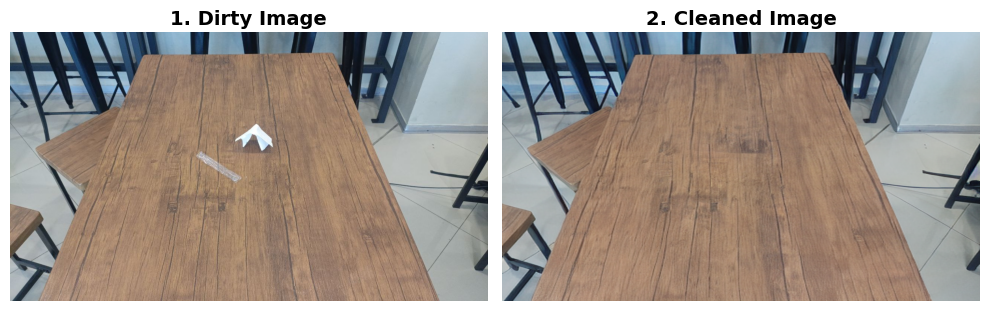

In [ ]:
test_files = sorted([f for f in os.listdir(config.test_image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
test_image_name = test_files[3]

test_image_path = f"{config.test_image_dir}/{test_image_name}"
test_mask_path = f"{config.test_mask_dir}/{test_image_name}"

if os.path.exists(test_image_path):
    # Load image
    image = Image.open(test_image_path).convert("RGB")
    mask = Image.open(test_mask_path).convert("L")

    # Simpan ukuran original image
    original_size = image.size

    # Resize ke 512x512 untuk processing
    image_resized = image.resize((512, 512), Image.LANCZOS)
    mask_resized = mask.resize((512, 512), Image.LANCZOS)

    print("Generating result...")
    result = pipe(
        prompt=config.train_prompt,
        image=image_resized,
        mask_image=mask_resized,
        negative_prompt=config.negative_prompt,
        num_inference_steps=50,
        guidance_scale=7.5,
        strength=0.99
    ).images[0]

    # Resize hasil ke ukuran original
    result_original_size = result.resize(original_size, Image.LANCZOS)

    # Save hasil
    result_original_size.save(f'/content/mydrive/MyDrive/Colab Notebooks/Computer Vision/test_clean/{test_image_name}')
    print(f"Saved to /content/mydrive/MyDrive/Colab Notebooks/Computer Vision/test_clean/{test_image_name}")

    # Perbandingan Dirty Image dengan Cleaned Image
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(image)
    axes[0].set_title("1. Dirty Image", fontsize=14, fontweight='bold')
    axes[0].axis('off')

    axes[1].imshow(result_original_size)
    axes[1].set_title(f"2. Cleaned Image", fontsize=14, fontweight='bold')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print(f"Test image not found: {test_image_path}")

## ControlNet
ControlNet adalah arsitektur neural network yang menambahkan kondisi kontrol tambahan pada model difusi untuk mengendalikan output gambar menggunakan kondisi tambahan, misalnya mask, depth map, sketch, atau edge map. Model ControlNet yang kami gunakan dibangun di atas Stable Diffusion 1.5 khusus untuk inpainting. Model ini memungkinkan kita untuk menghapus atau memodifikasi sampah yang sudah ditandai oleh mask, dan menggantinya dengan konteks sekitarnya. Model ini memiliki sekitar 1 miliar parameter.

Model ini kami ambil dari HuggingFace: https://huggingface.co/lllyasviel/control_v11p_sd15_inpaint

![image.png](markdown_image/controlnet.png)

### Import Libraries

In [ ]:
!pip install -U -q diffusers transformers accelerate peft huggingface-hub
!pip install -q bitsandbytes safetensors pillow xformers scikit-image lpips
!pip install -q controlnet_aux opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 MB 7.1 MB/s eta 0:00:00
   ━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.4/899.7 MB 132.9 MB/s eta 0:00:06
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Setup Hugging Face authentication
try:
    from google.colab import userdata
    from huggingface_hub import login

    hf_token = userdata.get('HF_TOKEN')
    login(token=hf_token)
    print("✅ Logged in to Hugging Face successfully!")
except Exception as e:
    print(f"⚠ HF Token not found: {e}")
    print("Continuing without authentication (public models only)")

# Import all libraries
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from diffusers import (
    StableDiffusionControlNetInpaintPipeline,
    ControlNetModel,
    AutoencoderKL,
    UNet2DConditionModel,
    DDPMScheduler
)
from transformers import CLIPTextModel, CLIPTokenizer
from peft import LoraConfig, get_peft_model, PeftModel
from PIL import Image
import os
from pathlib import Path
from tqdm import tqdm
import numpy as np
import lpips
from accelerate import Accelerator
import cv2

Mounted at /content/drive
⚠ HF Token not found: Secret HF_TOKEN does not exist.
Continuing without authentication (public models only)
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


### Cuda (GPU) Initialization

In [ ]:
# Check GPU
if torch.cuda.is_available():
    print(f"✓ GPU Available: {torch.cuda.get_device_name(0)}")
    print(f"✓ GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠ WARNING: No GPU detected!")

✓ GPU Available: Tesla T4
✓ GPU Memory: 15.83 GB


### Define Training Config

In [ ]:
class TrainingConfig:
    # Paths
    dataset_dir = "/content/mydrive/MyDrive/Colab Notebooks/Computer Vision"
    images_dir = f"{dataset_dir}/images"      # Dirty images (with trash)
    masks_dir = f"{dataset_dir}/masks"        # Mask trash area
    clean_images_dir = f"{dataset_dir}/clean" # Clean images (ground truth)
    output_dir = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/new_controlnet_lora_trash_inpainting"
    test_image_dir = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/test_images"
    test_mask_dir = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/test_masks"

    # Model - Pakai model ControlNet Inpaint dengan base stable difussion
    base_model = "runwayml/stable-diffusion-v1-5"
    controlnet_model = "lllyasviel/control_v11p_sd15_inpaint" 

    # LoRA settings
    lora_rank = 16
    lora_alpha = 32
    lora_dropout = 0.1

    # Training settings
    batch_size = 2 
    num_epochs = 10
    learning_rate = 1e-4
    gradient_accumulation_steps = 16 
    mixed_precision = "fp16"
    gradient_checkpointing = True

    # Image settings
    resolution = 512

    # Dataset split
    train_split = 0.95
    max_train_samples = None  # None = full dataset

    # Checkpointing
    save_steps = 200
    validation_steps = 100

    # Memory optimization
    enable_xformers = True  # hitung tanpa simpan full attention matrix
    dataloader_num_workers = 2

    # Prompts
    train_prompt = "clean background, clean environment, asphalt road, grass, rock, leaf"
    negative_prompt = "trash, rubish, garbage, litter, plastic bottle, bottle, can, plastic, paper, waste, debris"

    # Resume settings
    resume_from_checkpoint = None
    start_epoch = 0

config = TrainingConfig()

### Controlnet Helper

In [ ]:
# ControlNet Conditioning Helper Functions
def make_inpaint_condition(image, mask):
    """ Ganti warna objek yang dimask ke warna abu-abu agar inpainting lebih soft untuk controlnet """
    image = np.array(image).astype(np.float32) / 255.0
    mask = np.array(mask).astype(np.float32) / 255.0

    # Pastikan mask hanya memiliki 1 channel (grayscale)
    if len(mask.shape) == 3:
        mask = mask[:, :, 0]

    # Copy image dan warnain sampah dengan warna abu-abu
    masked_image = image.copy()
    masked_image[mask > 0.5] = 0.5  # Gray color for masked region

    # Convert to PIL
    masked_image = (masked_image * 255).astype(np.uint8)
    return Image.fromarray(masked_image)

def prepare_control_image(image, mask, resolution=512):
    """Siapkan control conditioning image untuk ControlNet"""
    # Resize
    image = image.resize((resolution, resolution), Image.LANCZOS)
    mask = mask.resize((resolution, resolution), Image.LANCZOS)

    # Buat inpaint condition
    control_image = make_inpaint_condition(image, mask)

    # Convert ke tensor
    control_image = np.array(control_image).astype(np.float32) / 255.0
    control_image = torch.from_numpy(control_image).permute(2, 0, 1)

    return control_image

### Custom Dataset for Trash Inpainting

In [ ]:
class ControlNetTrashInpaintingDataset(Dataset):
    def __init__(self, images_dir, masks_dir, clean_images_dir, tokenizer, resolution=512, max_samples=None):
        self.images_dir = Path(images_dir)
        self.masks_dir = Path(masks_dir)
        self.clean_images_dir = Path(clean_images_dir)
        self.tokenizer = tokenizer
        self.resolution = resolution

        # Ambil semua image
        self.image_files = sorted([f for f in os.listdir(images_dir)
                                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

        # Mengambil gambar sesuai limit pada config
        if max_samples:
            self.image_files = self.image_files[:max_samples]

        print(f"✓ Dataset initialized with {len(self.image_files)} images")
        print(f"  - Dirty images: {images_dir}")
        print(f"  - Masks: {masks_dir}")
        print(f"  - Clean images (ground truth): {clean_images_dir}")

    def __len__(self):
        return len(self.image_files)

    def preprocess_image(self, image):
        # resize ke 512 x 512
        image = image.resize((self.resolution, self.resolution), Image.LANCZOS)
        image = np.array(image).astype(np.float32) / 127.5 - 1.0
        image = torch.from_numpy(image).permute(2, 0, 1)
        return image

    def preprocess_mask(self, mask):
        # resize ke 512 x 512 dan pastikan masking biner
        mask = mask.resize((self.resolution, self.resolution), Image.LANCZOS)
        mask = np.array(mask).astype(np.float32) / 255.0
        mask = torch.from_numpy(mask).unsqueeze(0)
        return mask

    def __getitem__(self, idx):
        # buat path untuk masing-masing gambar
        img_name = self.image_files[idx]
        dirty_image_path = self.images_dir / img_name
        basename = Path(img_name).stem  
        mask_path = self.masks_dir / f"{basename}.png" 

        clean_image_path = self.clean_images_dir / img_name

        try:
            # Load semua image
            dirty_image = Image.open(dirty_image_path).convert("RGB")
            mask = Image.open(mask_path).convert("L")
            clean_image = Image.open(clean_image_path).convert("RGB")

            # Prepare ControlNet conditioning image
            control_image = prepare_control_image(dirty_image, mask, self.resolution)

            # Preprocess
            dirty_image = self.preprocess_image(dirty_image)
            mask = self.preprocess_mask(mask)
            clean_image = self.preprocess_image(clean_image)

            # Tokenize prompt
            text_inputs = self.tokenizer(
                config.train_prompt,
                padding="max_length",
                max_length=self.tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt"
            )

            return {
                "pixel_values": dirty_image,           # Original dirty image
                "conditioning_pixel_values": control_image,  # ControlNet input
                "mask": mask,                           # Mask
                "clean_values": clean_image,            # Ground truth
                "input_ids": text_inputs.input_ids[0],
                "filename": img_name
            }
        except Exception as e:
            print(f"⚠ Error loading {img_name}: {e}")
            return self.__getitem__((idx + 1) % len(self))

print("✓ ControlNet Dataset class defined")

### Checkpoint Detection for Resume Training

In [ ]:
checkpoint_dir = config.output_dir

print("\n" + "=" * 60)
print("CHECKING EXISTING CHECKPOINTS")
print("=" * 60)

if os.path.exists(checkpoint_dir):
    # Ambil dan sort semua checkpoint
    checkpoints = [d for d in os.listdir(checkpoint_dir) if d.startswith('checkpoint-')]
    checkpoints.sort(key=lambda x: int(x.split('-')[1]))

    if checkpoints:
        print(f"Found {len(checkpoints)} checkpoints:\n")
        for cp in checkpoints[-5:]:  # Show last 5
            print(f"  📁 {cp}")

        # ambil checkpoint terakhir
        latest_checkpoint = checkpoints[-1]
        print(f"\n✓ Latest checkpoint: {latest_checkpoint}")

        latest_step = int(latest_checkpoint.split('-')[1])
        print(f"✓ Training stopped at step: {latest_step}")

        # Auto-set resume
        config.resume_from_checkpoint = f"{checkpoint_dir}/{latest_checkpoint}"
        steps_per_epoch = 2398 // config.batch_size
        config.start_epoch = latest_step // steps_per_epoch
        print(f"✓ Will resume from epoch ~{config.start_epoch}")
    else:
        print("⚠ No checkpoints found. Starting fresh training.")
        config.resume_from_checkpoint = None
        config.start_epoch = 0
else:
    print(f"⚠ Checkpoint directory not found.")
    print("Starting training from scratch.")
    config.resume_from_checkpoint = None
    config.start_epoch = 0

if os.path.exists(f"{checkpoint_dir}/best_model"):
    print("\n✓ Best model checkpoint also available")

print("=" * 60)


CHECKING EXISTING CHECKPOINTS
Found 27 checkpoints:

  📁 checkpoint-4600
  📁 checkpoint-4800
  📁 checkpoint-5000
  📁 checkpoint-5200
  📁 checkpoint-5400

✓ Latest checkpoint: checkpoint-5400
✓ Training stopped at step: 5400
✓ Will resume from epoch ~4

✓ Best model checkpoint also available


### Model Evaluation Matrix (LPIPS)

![Foto 1](markdown_image/LPIPS.png)

In [ ]:
# Inisialisasi model LPIPS
lpips_model = None

def get_lpips_model():
    """Inisialisasi model LPIPS model (AlexNet)"""
    global lpips_model
    if lpips_model is None:
        print("Loading LPIPS model (AlexNet)...")
        lpips_model = lpips.LPIPS(net='alex').cuda()
        lpips_model.eval()
        print("✅ LPIPS model loaded")
    return lpips_model

def calculate_lpips(img1, img2):
    """Hitung LPIPS score (semakin kecil semakin bagus)"""
    model = get_lpips_model()

    # Pastikan tensor ada dalam GPU dan memiliki dimensi batch (format harus B, C, H, W)
    if img1.dim() == 3:
        img1 = img1.unsqueeze(0)
    if img2.dim() == 3:
        img2 = img2.unsqueeze(0)

    img1 = img1.cuda()
    img2 = img2.cuda()

    with torch.no_grad():
        lpips_score = model(img1, img2)

    return lpips_score.item()

def evaluate_batch_lpips(predicted_images, target_images):
    """Evaluasi LPIPS pada batch"""
    batch_size = predicted_images.shape[0]
    lpips_scores = []

    for i in range(batch_size):
        score = calculate_lpips(predicted_images[i], target_images[i])
        lpips_scores.append(score)

    return {
        'lpips': np.mean(lpips_scores),
        'lpips_std': np.std(lpips_scores)
    }

def validate_with_lpips(unet, controlnet, val_dataloader, vae, text_encoder,
                        noise_scheduler, accelerator, calculate_lpips_metric=True):
    """ Validasi LPIPS menggunakan ground truth (image yang sudah di blur sampahnya menggunakan YOLO)"""
    unet.eval()
    controlnet.eval()
    val_loss = 0
    all_lpips = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(val_dataloader):
            # Encode ground truth (image bersih) ke latent
            clean_latents = vae.encode(batch["clean_values"].to(dtype=torch.float16)).latent_dist.sample()
            clean_latents = clean_latents * vae.config.scaling_factor

            # Tambahin noise di seluruh latent gambar
            noise = torch.randn_like(clean_latents)
            bsz = clean_latents.shape[0]
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bsz,),
                device=clean_latents.device
            ).long()
            noisy_latents = noise_scheduler.add_noise(clean_latents, noise, timesteps)

            # Ambil ControlNet conditioning
            controlnet_image = batch["conditioning_pixel_values"].to(dtype=torch.float16)

            # ControlNet forward
            down_block_res_samples, mid_block_res_sample = controlnet(
                noisy_latents,
                timesteps,
                encoder_hidden_states=text_encoder(batch["input_ids"])[0],
                controlnet_cond=controlnet_image,
                return_dict=False,
            )

            # UNet prediction dengan ControlNet conditioning
            model_pred = unet(
                noisy_latents,
                timesteps,
                encoder_hidden_states=text_encoder(batch["input_ids"])[0],
                down_block_additional_residuals=down_block_res_samples,
                mid_block_additional_residual=mid_block_res_sample,
            ).sample

            loss = F.mse_loss(model_pred.float(), noise.float(), reduction="mean")
            val_loss += loss.item()

            # Hitung LPIPS
            if calculate_lpips_metric:
                predicted_latents = clean_latents + (model_pred - noise)
                predicted_latents = predicted_latents.to(dtype=torch.float16)
                predicted_images = vae.decode(predicted_latents / vae.config.scaling_factor).sample
                target_images = batch["clean_values"]

                batch_lpips = evaluate_batch_lpips(predicted_images, target_images)
                all_lpips.append(batch_lpips['lpips'])

    result = {'val_loss': val_loss / len(val_dataloader)}
    if all_lpips:
        result['lpips'] = np.mean(all_lpips)

    return result

### Training Function (with LoRA)

In [ ]:
def train_controlnet_lora():
    # otomatisasi backward, handle GPU, dll.
    accelerator = Accelerator(
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        mixed_precision=config.mixed_precision
    )

    torch.cuda.empty_cache()

    print("\n" + "=" * 60)
    print("LOADING BASE MODELS")
    print("=" * 60)

    tokenizer = CLIPTokenizer.from_pretrained(config.base_model, subfolder="tokenizer")
    text_encoder = CLIPTextModel.from_pretrained(config.base_model, subfolder="text_encoder", torch_dtype=torch.float16)
    vae = AutoencoderKL.from_pretrained(config.base_model, subfolder="vae", torch_dtype=torch.float16)
    unet = UNet2DConditionModel.from_pretrained(config.base_model, subfolder="unet", torch_dtype=torch.float16)
    noise_scheduler = DDPMScheduler.from_pretrained(config.base_model, subfolder="scheduler")

    # Load ControlNet
    controlnet = ControlNetModel.from_pretrained(config.controlnet_model, torch_dtype=torch.float16)

    print("✅ Base models loaded")
    print("✅ ControlNet loaded")

    # optimisasi memory
    if config.gradient_checkpointing:
        unet.enable_gradient_checkpointing()
        controlnet.enable_gradient_checkpointing()
        print("✅ Gradient checkpointing enabled")

    if config.enable_xformers:
        try:
            unet.enable_xformers_memory_efficient_attention()
            controlnet.enable_xformers_memory_efficient_attention()
            print("✅ xFormers enabled")
        except:
            print("⚠️ xFormers not available")

    # Additional memory optimization for batch_size 4
    if config.batch_size >= 4:
        print("⚠️ Batch size ≥4 detected. Applying aggressive memory optimizations...")
        torch.cuda.empty_cache()
        print("✅ Memory optimizations applied")

    # Freeze VAE dan text encoder
    vae.requires_grad_(False)
    text_encoder.requires_grad_(False)

    # Optimisasi hanya untuk Controlnet
    unet.requires_grad_(False)  

    # Load LoRA dari checkpoint atau inisialiasai LoRA
    if config.resume_from_checkpoint:
        print("\n" + "=" * 60)
        print("LOADING CHECKPOINT")
        print("=" * 60)
        print(f"Loading from: {config.resume_from_checkpoint}")

        try:
            controlnet = PeftModel.from_pretrained(controlnet, config.resume_from_checkpoint, is_trainable=True)
            print("✅ LoRA weights loaded from checkpoint")
        except Exception as e:
            print(f"⚠️ Error: {e}")
            print("Starting with fresh LoRA...")
            lora_config = LoraConfig(
                r=config.lora_rank,
                lora_alpha=config.lora_alpha,
                init_lora_weights="gaussian",
                target_modules=["to_k", "to_q", "to_v", "to_out.0"],
                lora_dropout=config.lora_dropout,
            )
            controlnet = get_peft_model(controlnet, lora_config)
            config.start_epoch = 0
    else:
        print("\n" + "=" * 60)
        print("CONFIGURING NEW LORA")
        print("=" * 60)

        lora_config = LoraConfig(
            r=config.lora_rank,
            lora_alpha=config.lora_alpha,
            init_lora_weights="gaussian",
            target_modules=["to_k", "to_q", "to_v", "to_out.0"],
            lora_dropout=config.lora_dropout,
        )
        controlnet = get_peft_model(controlnet, lora_config)

    controlnet.print_trainable_parameters()

    print("\n" + "=" * 60)
    print("LOADING DATASET")
    print("=" * 60)

    # Load dataset
    full_dataset = ControlNetTrashInpaintingDataset(
        config.images_dir,
        config.masks_dir,
        config.clean_images_dir,
        tokenizer,
        config.resolution,
        config.max_train_samples
    )

    train_size = int(config.train_split * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        full_dataset, [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )

    print(f"✅ Training samples: {len(train_dataset)}")
    print(f"✅ Validation samples: {len(val_dataset)}")

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.dataloader_num_workers,
        pin_memory=True
    )

    val_dataloader = DataLoader(
        val_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.dataloader_num_workers,
        pin_memory=True
    )

    # load optimizer (AdamW) - Hanya train ControlNet dengan LoRA
    optimizer = torch.optim.AdamW(
        controlnet.parameters(),
        lr=config.learning_rate,
        betas=(0.9, 0.999),
        weight_decay=0.01,
        eps=1e-8
    )

    num_training_steps = len(train_dataloader) * config.num_epochs
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(     # hanya finetune model tambahan
        optimizer,
        max_lr=config.learning_rate,
        total_steps=num_training_steps,
        pct_start=0.05,  
        anneal_strategy='cos',
        div_factor=25.0,  
        final_div_factor=10000.0
    )

    if config.resume_from_checkpoint:
        steps_to_skip = config.start_epoch * len(train_dataloader)
        for _ in range(steps_to_skip):
            lr_scheduler.step()

    # Prepare with accelerator
    controlnet, unet, optimizer, train_dataloader, val_dataloader, lr_scheduler = accelerator.prepare(
        controlnet, unet, optimizer, train_dataloader, val_dataloader, lr_scheduler
    )
    vae.to(accelerator.device)
    text_encoder.to(accelerator.device)

    print("\n" + "=" * 60)
    print("STARTING TRAINING")
    print("=" * 60)
    print(f"Starting from epoch: {config.start_epoch + 1}")
    print(f"Total epochs: {config.num_epochs}")
    print(f"Steps per epoch: {len(train_dataloader)}")
    print("Architecture: ControlNet + LoRA")
    print("Metric: LPIPS")
    print("=" * 60 + "\n")

    global_step = config.start_epoch * len(train_dataloader)

    # Load matrix terbaik
    best_metrics_path = f"{config.output_dir}/best_metrics.txt"
    if config.resume_from_checkpoint and os.path.exists(best_metrics_path):
        try:
            with open(best_metrics_path, 'r') as f:
                lines = f.readlines()
                best_val_loss = float(lines[0].strip())
                best_lpips = float(lines[1].strip())
            print(f"📊 Loaded previous best metrics:")
            print(f"   Best validation loss: {best_val_loss:.4f}")
            print(f"   Best LPIPS: {best_lpips:.4f}")
            print("=" * 60 + "\n")
        except:
            print("⚠️ Could not load previous best metrics. Starting fresh.")
            best_val_loss = float('inf')
            best_lpips = float('inf')
    else:
        best_val_loss = float('inf')
        best_lpips = float('inf')

    for epoch in range(config.start_epoch, config.num_epochs):
        controlnet.train()
        unet.eval()  # UNet stays in eval mode (frozen)
        epoch_loss = 0

        progress_bar = tqdm(
            train_dataloader,
            desc=f"Epoch {epoch+1}/{config.num_epochs}",
            disable=not accelerator.is_local_main_process
        )

        for step, batch in enumerate(progress_bar):
            with accelerator.accumulate(controlnet):
                # Encode clean images (ground truth)
                with torch.no_grad():
                    clean_latents = vae.encode(batch["clean_values"].to(dtype=torch.float16)).latent_dist.sample()
                    clean_latents = clean_latents * vae.config.scaling_factor

                # Add noise
                noise = torch.randn_like(clean_latents)
                bsz = clean_latents.shape[0]
                # variasi noise
                timesteps = torch.randint(
                    0, noise_scheduler.config.num_train_timesteps, (bsz,),
                    device=clean_latents.device
                ).long()

                # Tambahkan noise ke latent
                noisy_latents = noise_scheduler.add_noise(clean_latents, noise, timesteps)

                # Ambil ControlNet conditioning
                controlnet_image = batch["conditioning_pixel_values"].to(dtype=torch.float16)

                # Ambil text embeddings
                with torch.no_grad():
                    encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # ControlNet forward pass (trainable)
                down_block_res_samples, mid_block_res_sample = controlnet(
                    noisy_latents,
                    timesteps,
                    encoder_hidden_states=encoder_hidden_states,
                    controlnet_cond=controlnet_image,
                    return_dict=False,
                )

                # UNet prediction dengan ControlNet conditioning
                # UNet frozen tapi tetap dibutuhkan untuk forward pass untuk menghitung loss
                with torch.set_grad_enabled(True):
                    model_pred = unet(
                        noisy_latents,
                        timesteps,
                        encoder_hidden_states=encoder_hidden_states,
                        down_block_additional_residuals=[sample.to(dtype=torch.float16) for sample in down_block_res_samples],
                        mid_block_additional_residual=mid_block_res_sample.to(dtype=torch.float16),
                    ).sample

                # Hitung loss
                loss = F.mse_loss(model_pred.float(), noise.float(), reduction="mean")

                # backprop dengan accelerator
                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(controlnet.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            epoch_loss += loss.item()
            current_lr = optimizer.param_groups[0]['lr']
            progress_bar.set_postfix({
                "loss": f"{loss.item():.4f}",
                "lr": f"{current_lr:.2e}",
                "step": global_step
            })
            global_step += 1

            # Hitung validasi menggunakan LPIPS
            if global_step % config.validation_steps == 0:
                metrics = validate_with_lpips(
                    unet, controlnet, val_dataloader, vae, text_encoder,
                    noise_scheduler, accelerator, calculate_lpips_metric=True
                )

                print(f"{'='*60}")

                val_loss = metrics['val_loss']
                current_lpips = metrics.get('lpips', float('inf'))

                # Save best model berdasarkan LPIPS
                if current_lpips < best_lpips:
                    best_lpips = current_lpips
                    best_val_loss = val_loss
                    save_path = f"{config.output_dir}/best_model"
                    os.makedirs(save_path, exist_ok=True)
                    accelerator.unwrap_model(controlnet).save_pretrained(save_path)

                    # Save best metrics to file
                    with open(f"{config.output_dir}/best_metrics.txt", 'w') as f:
                        f.write(f"{best_val_loss}\n")
                        f.write(f"{best_lpips}\n")
                        f.write(f"Step: {global_step}\n")
                        f.write(f"Epoch: {epoch+1}\n")

                    print(f"✅ Best model saved! (LPIPS: {current_lpips:.4f}, loss: {val_loss:.4f})")
                else:
                    print(f"📊 Current LPIPS: {current_lpips:.4f} (Best: {best_lpips:.4f})")

                controlnet.train()

            # Save checkpoint
            if global_step % config.save_steps == 0:
                save_path = f"{config.output_dir}/checkpoint-{global_step}"
                os.makedirs(save_path, exist_ok=True)
                accelerator.unwrap_model(controlnet).save_pretrained(save_path)
                print(f"\n✅ Checkpoint saved at step {global_step}")

            # Clear cache periodically
            if global_step % 100 == 0:
                torch.cuda.empty_cache()

        avg_loss = epoch_loss / len(train_dataloader)
        print(f"\n{'='*60}")
        print(f"Epoch {epoch+1}/{config.num_epochs} Complete")
        print(f"Average Loss: {avg_loss:.4f}")
        print(f"Learning Rate: {current_lr:.2e}")
        print(f"Global Step: {global_step}")
        print(f"📊 Best LPIPS so far: {best_lpips:.4f}")
        print(f"📊 Best Val Loss so far: {best_val_loss:.4f}")
        print(f"{'='*60}\n")

    print("\n" + "=" * 60)
    print("TRAINING COMPLETE!")
    print("=" * 60)
    os.makedirs(config.output_dir, exist_ok=True)
    accelerator.unwrap_model(controlnet).save_pretrained(config.output_dir)
    print(f"✅ Final model saved to: {config.output_dir}")
    print(f"✅ Best LPIPS: {best_lpips:.4f}")
    print(f"✅ Best validation loss: {best_val_loss:.4f}")
    print("=" * 60)

print("✅ ControlNet + LoRA training function defined")

✅ ControlNet + LoRA training function defined


### Model Evaluation Before Training

In [ ]:
# Inisialisasi LPIPS
lpips_model = get_lpips_model()

# Inisialisasi accelerator
accelerator = Accelerator(mixed_precision=config.mixed_precision)

# Load base model
tokenizer = CLIPTokenizer.from_pretrained(config.base_model, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(config.base_model, subfolder="text_encoder", torch_dtype=torch.float16)
vae = AutoencoderKL.from_pretrained(config.base_model, subfolder="vae", torch_dtype=torch.float16)
unet = UNet2DConditionModel.from_pretrained(config.base_model, subfolder="unet", torch_dtype=torch.float16)
noise_scheduler = DDPMScheduler.from_pretrained(config.base_model, subfolder="scheduler")
controlnet = ControlNetModel.from_pretrained(config.controlnet_model, torch_dtype=torch.float16)

vae.to(accelerator.device)
text_encoder.to(accelerator.device)

# Load validation dataset
full_dataset = ControlNetTrashInpaintingDataset(
    config.images_dir,
    config.masks_dir,
    config.clean_images_dir,
    tokenizer,
    config.resolution,
    config.max_train_samples
)

train_size = int(config.train_split * len(full_dataset))
val_size = len(full_dataset) - train_size
_, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

print(f"Validation samples: {len(val_dataset)}")

val_dataloader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.dataloader_num_workers,
    pin_memory=True
)

val_dataloader = accelerator.prepare(val_dataloader)

""" 1. BASELINE MODEL (Tanpa Fine-tuning) """
print("\n" + "=" * 60)
print("EVALUATING BASELINE MODEL")
print("=" * 60)

# Load baseline UNet (tanpa LoRA)
unet.to(accelerator.device)
unet.eval()

controlnet.to(accelerator.device)
controlnet.eval()

# Evaluasi
metrics = validate_with_lpips(
    unet,
    controlnet,
    val_dataloader,
    vae,
    text_encoder,
    noise_scheduler,
    accelerator,
    calculate_lpips_metric=True
    )

print(f"Baseline Model Metrics:")
print(f"  Loss: {metrics['val_loss']:.4f}")
print(f"  LPIPS: {metrics['lpips']:.4f}")
print(f"{'='*60}")

Loading LPIPS model (AlexNet)...
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth
✅ LPIPS model loaded
✓ Dataset initialized with 2398 images
  - Dirty images: /content/drive/MyDrive/Colab Notebooks/Computer Vision/new_images
  - Masks: /content/drive/MyDrive/Colab Notebooks/Computer Vision/new_masks
  - Clean images (ground truth): /content/drive/MyDrive/Colab Notebooks/Computer Vision/new_clean
Validation samples: 120

EVALUATING BASELINE MODEL
Baseline Model Metrics:
  Loss: 0.1369
  LPIPS: 0.4495


### Training

In [ ]:
print("\n🚀 Starting/Resuming training process...")

if config.resume_from_checkpoint:
    print(f"📂 Resuming from checkpoint")
    print(f"📊 Starting from epoch: {config.start_epoch + 1}/{config.num_epochs}")
else:
    print("🆕 Starting fresh training")

train_controlnet_lora()


🚀 Starting/Resuming training process...
📂 Resuming from checkpoint
📊 Starting from epoch: 5/10

LOADING BASE MODELS


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

✅ Base models loaded
✅ ControlNet loaded
✅ Gradient checkpointing enabled
✅ xFormers enabled

LOADING CHECKPOINT
Loading from: /content/drive/MyDrive/UAS Computer Vision/new_controlnet_lora_trash_inpainting/checkpoint-5400
✅ LoRA weights loaded from checkpoint
trainable params: 1,462,272 || all params: 362,741,392 || trainable%: 0.4031

LOADING DATASET
✓ Dataset initialized with 2399 images
  - Dirty images: /content/drive/MyDrive/UAS Computer Vision/dataset_inpaint/images
  - Masks: /content/drive/MyDrive/UAS Computer Vision/dataset_inpaint/masks
  - Clean images (ground truth): /content/drive/MyDrive/UAS Computer Vision/new_clean
✅ Training samples: 2279
✅ Validation samples: 120

STARTING TRAINING
Starting from epoch: 5
Total epochs: 10
Steps per epoch: 1140
Architecture: ControlNet + LoRA
Metric: LPIPS

📊 Loaded previous best metrics:
   Best validation loss: 0.1096
   Best LPIPS: 0.2628



Epoch 5/10:   3%|▎         | 39/1140 [01:27<16:49,  1.09it/s, loss=0.0495, lr=7.00e-05, step=4599]

Loading LPIPS model (AlexNet)...
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth



  0%|          | 0.00/233M [00:00<?, ?B/s]
  5%|▌         | 12.5M/233M [00:00<00:01, 131MB/s]
 12%|█▏        | 29.0M/233M [00:00<00:01, 154MB/s]
 19%|█▉        | 43.8M/233M [00:00<00:01, 109MB/s]
 24%|██▍       | 55.4M/233M [00:00<00:01, 102MB/s]
 29%|██▉       | 67.1M/233M [00:00<00:01, 108MB/s]
 35%|███▍      | 80.8M/233M [00:00<00:01, 118MB/s]
 40%|███▉      | 92.6M/233M [00:00<00:01, 93.8MB/s]
 44%|████▍     | 103M/233M [00:01<00:01, 91.7MB/s] 
 49%|████▉     | 115M/233M [00:01<00:01, 100MB/s] 
 55%|█████▌    | 129M/233M [00:01<00:00, 114MB/s]
 61%|██████    | 142M/233M [00:01<00:00, 119MB/s]
 66%|██████▌   | 154M/233M [00:01<00:00, 113MB/s]
 71%|███████   | 165M/233M [00:01<00:00, 99.2MB/s]
 75%|███████▌  | 176M/233M [00:01<00:00, 103MB/s] 
 80%|███████▉  | 186M/233M [00:01<00:00, 97.1MB/s]
 84%|████████▍ | 196M/233M [00:01<00:00, 89.4MB/s]
 88%|████████▊ | 206M/233M [00:02<00:00, 94.2MB/s]
 94%|█████████▎| 218M/233M [00:02<00:00, 103MB/s] 
100%|██████████| 233M/233M [00:02<00:00

Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth
✅ LPIPS model loaded
📊 Current LPIPS: 0.3419 (Best: 0.2628)


Epoch 5/10:   4%|▎         | 40/1140 [02:29<5:59:10, 19.59s/it, loss=0.0495, lr=7.00e-05, step=4599]


✅ Checkpoint saved at step 4600


Epoch 5/10:  12%|█▏        | 140/1140 [04:33<2:40:33,  9.63s/it, loss=0.0276, lr=7.00e-05, step=4699]

📊 Current LPIPS: 0.3664 (Best: 0.2628)


Epoch 5/10:  21%|██        | 239/1140 [06:07<13:47,  1.09it/s, loss=0.1541, lr=6.99e-05, step=4799]

📊 Current LPIPS: 0.2743 (Best: 0.2628)


Epoch 5/10:  21%|██        | 240/1140 [06:37<2:29:04,  9.94s/it, loss=0.1541, lr=6.99e-05, step=4799]


✅ Checkpoint saved at step 4800


Epoch 5/10:  30%|██▉       | 340/1140 [08:39<2:07:24,  9.56s/it, loss=0.0073, lr=6.98e-05, step=4899]

📊 Current LPIPS: 0.4489 (Best: 0.2628)


Epoch 5/10:  39%|███▊      | 439/1140 [10:13<10:54,  1.07it/s, loss=0.3734, lr=6.97e-05, step=4999]

📊 Current LPIPS: 0.3171 (Best: 0.2628)


Epoch 5/10:  39%|███▊      | 440/1140 [10:43<1:58:42, 10.18s/it, loss=0.3734, lr=6.97e-05, step=4999]


✅ Checkpoint saved at step 5000


Epoch 5/10:  47%|████▋     | 540/1140 [12:44<1:34:06,  9.41s/it, loss=0.0469, lr=6.96e-05, step=5099]

📊 Current LPIPS: 0.5004 (Best: 0.2628)


Epoch 5/10:  56%|█████▌    | 639/1140 [14:17<09:27,  1.13s/it, loss=0.2001, lr=6.95e-05, step=5199]

📊 Current LPIPS: 0.3826 (Best: 0.2628)


Epoch 5/10:  56%|█████▌    | 640/1140 [14:47<1:24:14, 10.11s/it, loss=0.2001, lr=6.95e-05, step=5199]


✅ Checkpoint saved at step 5200


Epoch 5/10:  65%|██████▍   | 740/1140 [16:48<1:02:35,  9.39s/it, loss=0.0787, lr=6.95e-05, step=5299]

📊 Current LPIPS: 0.3375 (Best: 0.2628)


Epoch 5/10:  74%|███████▎  | 839/1140 [18:21<04:16,  1.17it/s, loss=0.0999, lr=6.94e-05, step=5399]

📊 Current LPIPS: 0.3920 (Best: 0.2628)


Epoch 5/10:  74%|███████▎  | 840/1140 [18:51<48:52,  9.78s/it, loss=0.0999, lr=6.94e-05, step=5399]


✅ Checkpoint saved at step 5400


Epoch 5/10:  82%|████████▏ | 940/1140 [20:54<31:31,  9.46s/it, loss=0.0470, lr=6.93e-05, step=5499]

📊 Current LPIPS: 0.2991 (Best: 0.2628)


Epoch 5/10:  90%|████████▉ | 1025/1140 [22:14<01:47,  1.07it/s, loss=0.0131, lr=6.92e-05, step=5584]

⚠ Error loading 50833400303_77a8159095_z.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/UAS Computer Vision/new_clean/50833400303_77a8159095_z.jpg'


Epoch 5/10:  91%|█████████ | 1040/1140 [22:56<16:05,  9.65s/it, loss=0.0220, lr=6.92e-05, step=5599]

📊 Current LPIPS: 0.2829 (Best: 0.2628)

✅ Checkpoint saved at step 5600


Epoch 5/10: 100%|██████████| 1140/1140 [24:58<00:00,  1.31s/it, loss=0.0886, lr=6.91e-05, step=5699]


📊 Current LPIPS: 0.3982 (Best: 0.2628)

Epoch 5/10 Complete
Average Loss: 0.1121
Learning Rate: 6.91e-05
Global Step: 5700
📊 Best LPIPS so far: 0.2628
📊 Best Val Loss so far: 0.1096



Epoch 6/10:   9%|▉         | 100/1140 [01:50<2:41:51,  9.34s/it, loss=0.0780, lr=6.90e-05, step=5799]

📊 Current LPIPS: 0.4174 (Best: 0.2628)

✅ Checkpoint saved at step 5800


Epoch 6/10:  18%|█▊        | 200/1140 [03:41<2:27:06,  9.39s/it, loss=0.0606, lr=6.89e-05, step=5899]

📊 Current LPIPS: 0.3333 (Best: 0.2628)


Epoch 6/10:  26%|██▋       | 300/1140 [05:32<2:12:53,  9.49s/it, loss=0.1498, lr=6.89e-05, step=5999]

📊 Current LPIPS: 0.3024 (Best: 0.2628)

✅ Checkpoint saved at step 6000


Epoch 6/10:  35%|███▌      | 400/1140 [07:23<1:55:10,  9.34s/it, loss=0.0676, lr=6.88e-05, step=6099]

📊 Current LPIPS: 0.4852 (Best: 0.2628)


Epoch 6/10:  44%|████▍     | 500/1140 [09:13<1:39:28,  9.33s/it, loss=0.2040, lr=6.87e-05, step=6199]

📊 Current LPIPS: 0.4484 (Best: 0.2628)

✅ Checkpoint saved at step 6200


Epoch 6/10:  53%|█████▎    | 600/1140 [11:03<1:23:45,  9.31s/it, loss=0.0239, lr=6.86e-05, step=6299]

📊 Current LPIPS: 0.3261 (Best: 0.2628)


Epoch 6/10:  61%|██████▏   | 700/1140 [12:53<1:08:26,  9.33s/it, loss=0.4490, lr=6.85e-05, step=6399]

📊 Current LPIPS: 0.4145 (Best: 0.2628)

✅ Checkpoint saved at step 6400


Epoch 6/10:  70%|███████   | 800/1140 [14:44<52:47,  9.31s/it, loss=0.2645, lr=6.84e-05, step=6499]

📊 Current LPIPS: 0.3462 (Best: 0.2628)


Epoch 6/10:  77%|███████▋  | 878/1140 [15:48<03:32,  1.23it/s, loss=0.0613, lr=6.84e-05, step=6577]

⚠ Error loading 50833400303_77a8159095_z.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/UAS Computer Vision/new_clean/50833400303_77a8159095_z.jpg'


Epoch 6/10:  79%|███████▉  | 900/1140 [16:35<38:07,  9.53s/it, loss=0.0309, lr=6.84e-05, step=6599]

📊 Current LPIPS: 0.3513 (Best: 0.2628)

✅ Checkpoint saved at step 6600


Epoch 6/10:  88%|████████▊ | 1000/1140 [18:25<21:52,  9.38s/it, loss=0.2419, lr=6.83e-05, step=6699]

📊 Current LPIPS: 0.4483 (Best: 0.2628)


Epoch 6/10:  96%|█████████▋| 1100/1140 [20:15<06:12,  9.30s/it, loss=0.2342, lr=6.82e-05, step=6799]

📊 Current LPIPS: 0.4075 (Best: 0.2628)

✅ Checkpoint saved at step 6800


Epoch 6/10: 100%|██████████| 1140/1140 [20:47<00:00,  1.09s/it, loss=0.0785, lr=6.81e-05, step=6839]



Epoch 6/10 Complete
Average Loss: 0.1112
Learning Rate: 6.81e-05
Global Step: 6840
📊 Best LPIPS so far: 0.2628
📊 Best Val Loss so far: 0.1096



Epoch 7/10:   5%|▌         | 60/1140 [01:18<2:47:10,  9.29s/it, loss=0.1009, lr=6.81e-05, step=6899]

📊 Current LPIPS: 0.2953 (Best: 0.2628)


Epoch 7/10:  14%|█▍        | 160/1140 [03:08<2:32:41,  9.35s/it, loss=0.0778, lr=6.80e-05, step=6999]

📊 Current LPIPS: 0.5034 (Best: 0.2628)

✅ Checkpoint saved at step 7000


Epoch 7/10:  23%|██▎       | 260/1140 [04:58<2:16:11,  9.29s/it, loss=0.3567, lr=6.79e-05, step=7099]

📊 Current LPIPS: 0.4284 (Best: 0.2628)


Epoch 7/10:  32%|███▏      | 360/1140 [06:49<2:02:33,  9.43s/it, loss=0.2266, lr=6.78e-05, step=7199]

📊 Current LPIPS: 0.3850 (Best: 0.2628)

✅ Checkpoint saved at step 7200


Epoch 7/10:  40%|████      | 460/1140 [08:39<1:45:44,  9.33s/it, loss=0.0501, lr=6.78e-05, step=7299]

📊 Current LPIPS: 0.2998 (Best: 0.2628)


Epoch 7/10:  49%|████▉     | 560/1140 [10:29<1:29:49,  9.29s/it, loss=0.0954, lr=6.77e-05, step=7399]

📊 Current LPIPS: 0.4268 (Best: 0.2628)

✅ Checkpoint saved at step 7400


Epoch 7/10:  58%|█████▊    | 660/1140 [12:19<1:14:14,  9.28s/it, loss=0.1206, lr=6.76e-05, step=7499]

📊 Current LPIPS: 0.4217 (Best: 0.2628)


Epoch 7/10:  67%|██████▋   | 759/1140 [13:41<05:09,  1.23it/s, loss=0.0283, lr=6.75e-05, step=7599]

Epoch 7/10:  67%|██████▋   | 760/1140 [14:11<1:01:46,  9.75s/it, loss=0.0283, lr=6.75e-05, step=7599]

✅ Best model saved! (LPIPS: 0.2390, loss: 0.1382)

✅ Checkpoint saved at step 7600


Epoch 7/10:  75%|███████▌  | 860/1140 [16:02<44:12,  9.47s/it, loss=0.2842, lr=6.74e-05, step=7699]

📊 Current LPIPS: 0.4240 (Best: 0.2390)


Epoch 7/10:  80%|███████▉  | 909/1140 [16:42<03:09,  1.22it/s, loss=0.0581, lr=6.74e-05, step=7748]

⚠ Error loading 50833400303_77a8159095_z.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/UAS Computer Vision/new_clean/50833400303_77a8159095_z.jpg'


Epoch 7/10:  84%|████████▍ | 960/1140 [17:52<27:54,  9.30s/it, loss=0.0657, lr=6.73e-05, step=7799]

📊 Current LPIPS: 0.5421 (Best: 0.2390)

✅ Checkpoint saved at step 7800


Epoch 7/10:  93%|█████████▎| 1060/1140 [19:42<12:24,  9.30s/it, loss=0.3258, lr=6.72e-05, step=7899]

📊 Current LPIPS: 0.3714 (Best: 0.2390)


Epoch 7/10: 100%|██████████| 1140/1140 [20:47<00:00,  1.09s/it, loss=0.1342, lr=6.72e-05, step=7979]



Epoch 7/10 Complete
Average Loss: 0.1148
Learning Rate: 6.72e-05
Global Step: 7980
📊 Best LPIPS so far: 0.2390
📊 Best Val Loss so far: 0.1382



Epoch 8/10:   2%|▏         | 20/1140 [00:45<2:53:59,  9.32s/it, loss=0.1006, lr=6.72e-05, step=7999]

📊 Current LPIPS: 0.4103 (Best: 0.2390)

✅ Checkpoint saved at step 8000


Epoch 8/10:  11%|█         | 120/1140 [02:35<2:37:59,  9.29s/it, loss=0.0569, lr=6.71e-05, step=8099]

📊 Current LPIPS: 0.3855 (Best: 0.2390)


Epoch 8/10:  19%|█▉        | 220/1140 [04:26<2:24:04,  9.40s/it, loss=0.0733, lr=6.70e-05, step=8199]

📊 Current LPIPS: 0.3615 (Best: 0.2390)

✅ Checkpoint saved at step 8200


Epoch 8/10:  28%|██▊       | 320/1140 [06:16<2:09:23,  9.47s/it, loss=0.0233, lr=6.69e-05, step=8299]

📊 Current LPIPS: 0.4175 (Best: 0.2390)


Epoch 8/10:  37%|███▋      | 420/1140 [08:06<1:51:38,  9.30s/it, loss=0.0308, lr=6.68e-05, step=8399]

📊 Current LPIPS: 0.3272 (Best: 0.2390)

✅ Checkpoint saved at step 8400


Epoch 8/10:  46%|████▌     | 520/1140 [09:57<1:36:10,  9.31s/it, loss=0.3121, lr=6.67e-05, step=8499]

📊 Current LPIPS: 0.3784 (Best: 0.2390)


Epoch 8/10:  54%|█████▍    | 620/1140 [11:47<1:20:37,  9.30s/it, loss=0.4223, lr=6.66e-05, step=8599]

📊 Current LPIPS: 0.3334 (Best: 0.2390)

✅ Checkpoint saved at step 8600


Epoch 8/10:  60%|█████▉    | 682/1140 [12:38<06:16,  1.22it/s, loss=0.0029, lr=6.66e-05, step=8661]

⚠ Error loading 50833400303_77a8159095_z.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/UAS Computer Vision/new_clean/50833400303_77a8159095_z.jpg'


Epoch 8/10:  63%|██████▎   | 720/1140 [13:37<1:05:10,  9.31s/it, loss=0.0081, lr=6.66e-05, step=8699]

📊 Current LPIPS: 0.3814 (Best: 0.2390)


Epoch 8/10:  72%|███████▏  | 820/1140 [15:28<49:39,  9.31s/it, loss=0.1226, lr=6.65e-05, step=8799]

📊 Current LPIPS: 0.5033 (Best: 0.2390)

✅ Checkpoint saved at step 8800


Epoch 8/10:  81%|████████  | 920/1140 [17:18<34:02,  9.29s/it, loss=0.0830, lr=6.64e-05, step=8899]

📊 Current LPIPS: 0.3252 (Best: 0.2390)


Epoch 8/10:  89%|████████▉ | 1020/1140 [19:09<19:02,  9.52s/it, loss=0.0322, lr=6.63e-05, step=8999]

📊 Current LPIPS: 0.3059 (Best: 0.2390)

✅ Checkpoint saved at step 9000


Epoch 8/10:  98%|█████████▊| 1120/1140 [20:59<03:06,  9.30s/it, loss=0.0088, lr=6.62e-05, step=9099]

📊 Current LPIPS: 0.4735 (Best: 0.2390)


Epoch 8/10: 100%|██████████| 1140/1140 [21:15<00:00,  1.12s/it, loss=0.2713, lr=6.62e-05, step=9119]



Epoch 8/10 Complete
Average Loss: 0.1089
Learning Rate: 6.62e-05
Global Step: 9120
📊 Best LPIPS so far: 0.2390
📊 Best Val Loss so far: 0.1382



Epoch 9/10:   7%|▋         | 80/1140 [01:34<2:44:06,  9.29s/it, loss=0.0817, lr=6.61e-05, step=9199]

📊 Current LPIPS: 0.4216 (Best: 0.2390)

✅ Checkpoint saved at step 9200


Epoch 9/10:  16%|█▌        | 180/1140 [03:24<2:28:15,  9.27s/it, loss=0.0619, lr=6.60e-05, step=9299]

📊 Current LPIPS: 0.4023 (Best: 0.2390)


Epoch 9/10:  25%|██▍       | 280/1140 [05:14<2:13:51,  9.34s/it, loss=0.0592, lr=6.59e-05, step=9399]

📊 Current LPIPS: 0.3826 (Best: 0.2390)

✅ Checkpoint saved at step 9400


Epoch 9/10:  33%|███▎      | 380/1140 [07:04<1:57:33,  9.28s/it, loss=0.1984, lr=6.59e-05, step=9499]

📊 Current LPIPS: 0.3940 (Best: 0.2390)


Epoch 9/10:  42%|████▏     | 480/1140 [08:55<1:44:06,  9.46s/it, loss=0.4944, lr=6.58e-05, step=9599]

📊 Current LPIPS: 0.3864 (Best: 0.2390)

✅ Checkpoint saved at step 9600


Epoch 9/10:  51%|█████     | 580/1140 [10:45<1:26:49,  9.30s/it, loss=0.0777, lr=6.57e-05, step=9699]

📊 Current LPIPS: 0.3652 (Best: 0.2390)


Epoch 9/10:  60%|█████▉    | 680/1140 [12:36<1:11:38,  9.34s/it, loss=0.0090, lr=6.56e-05, step=9799]

📊 Current LPIPS: 0.3282 (Best: 0.2390)

✅ Checkpoint saved at step 9800


Epoch 9/10:  64%|██████▎   | 724/1140 [13:12<05:42,  1.22it/s, loss=0.0079, lr=6.56e-05, step=9843]

⚠ Error loading 50833400303_77a8159095_z.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/UAS Computer Vision/new_clean/50833400303_77a8159095_z.jpg'


Epoch 9/10:  68%|██████▊   | 780/1140 [14:26<55:47,  9.30s/it, loss=0.0779, lr=6.55e-05, step=9899]

📊 Current LPIPS: 0.4575 (Best: 0.2390)


Epoch 9/10:  77%|███████▋  | 880/1140 [16:16<40:31,  9.35s/it, loss=0.0158, lr=6.54e-05, step=9999]

📊 Current LPIPS: 0.4726 (Best: 0.2390)

✅ Checkpoint saved at step 10000


Epoch 9/10:  86%|████████▌ | 980/1140 [18:06<24:44,  9.28s/it, loss=0.0150, lr=6.53e-05, step=10099]

📊 Current LPIPS: 0.5075 (Best: 0.2390)


Epoch 9/10:  95%|█████████▍| 1080/1140 [19:57<09:19,  9.32s/it, loss=0.1629, lr=6.53e-05, step=10199]

📊 Current LPIPS: 0.4319 (Best: 0.2390)

✅ Checkpoint saved at step 10200


Epoch 9/10: 100%|██████████| 1140/1140 [20:46<00:00,  1.09s/it, loss=0.0319, lr=6.52e-05, step=10259]



Epoch 9/10 Complete
Average Loss: 0.1103
Learning Rate: 6.52e-05
Global Step: 10260
📊 Best LPIPS so far: 0.2390
📊 Best Val Loss so far: 0.1382



Epoch 10/10:   4%|▎         | 40/1140 [01:02<2:54:04,  9.50s/it, loss=0.0085, lr=6.52e-05, step=10299]

📊 Current LPIPS: 0.3600 (Best: 0.2390)


Epoch 10/10:  12%|█▏        | 140/1140 [02:52<2:35:23,  9.32s/it, loss=0.0721, lr=6.51e-05, step=10399]

📊 Current LPIPS: 0.4726 (Best: 0.2390)

✅ Checkpoint saved at step 10400


Epoch 10/10:  21%|██        | 240/1140 [04:43<2:19:32,  9.30s/it, loss=0.0515, lr=6.50e-05, step=10499]

📊 Current LPIPS: 0.3116 (Best: 0.2390)


Epoch 10/10:  30%|██▉       | 340/1140 [06:33<2:04:17,  9.32s/it, loss=0.1733, lr=6.49e-05, step=10599]

📊 Current LPIPS: 0.3195 (Best: 0.2390)

✅ Checkpoint saved at step 10600


Epoch 10/10:  39%|███▊      | 440/1140 [08:23<1:48:15,  9.28s/it, loss=0.0996, lr=6.48e-05, step=10699]

📊 Current LPIPS: 0.3955 (Best: 0.2390)


Epoch 10/10:  47%|████▋     | 540/1140 [10:14<1:33:14,  9.32s/it, loss=0.2127, lr=6.47e-05, step=10799]

📊 Current LPIPS: 0.4889 (Best: 0.2390)

✅ Checkpoint saved at step 10800


Epoch 10/10:  54%|█████▍    | 615/1140 [11:15<07:06,  1.23it/s, loss=0.1045, lr=6.47e-05, step=10874]

⚠ Error loading 50833400303_77a8159095_z.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/UAS Computer Vision/new_clean/50833400303_77a8159095_z.jpg'


Epoch 10/10:  56%|█████▌    | 640/1140 [12:04<1:17:35,  9.31s/it, loss=0.0197, lr=6.46e-05, step=10899]

📊 Current LPIPS: 0.4596 (Best: 0.2390)


Epoch 10/10:  65%|██████▍   | 740/1140 [13:55<1:03:15,  9.49s/it, loss=0.0186, lr=6.46e-05, step=10999]

📊 Current LPIPS: 0.4274 (Best: 0.2390)

✅ Checkpoint saved at step 11000


Epoch 10/10:  74%|███████▎  | 840/1140 [15:45<46:37,  9.32s/it, loss=0.0172, lr=6.45e-05, step=11099]

📊 Current LPIPS: 0.2949 (Best: 0.2390)


Epoch 10/10:  82%|████████▏ | 940/1140 [17:35<31:00,  9.30s/it, loss=0.2206, lr=6.44e-05, step=11199]

📊 Current LPIPS: 0.3514 (Best: 0.2390)

✅ Checkpoint saved at step 11200


Epoch 10/10:  91%|█████████ | 1040/1140 [19:25<15:30,  9.30s/it, loss=0.0874, lr=6.43e-05, step=11299]

📊 Current LPIPS: 0.4113 (Best: 0.2390)


Epoch 10/10: 100%|██████████| 1140/1140 [21:15<00:00,  1.12s/it, loss=0.0023, lr=6.42e-05, step=11399]

📊 Current LPIPS: 0.3245 (Best: 0.2390)

✅ Checkpoint saved at step 11400

Epoch 10/10 Complete
Average Loss: 0.1102
Learning Rate: 6.42e-05
Global Step: 11400
📊 Best LPIPS so far: 0.2390
📊 Best Val Loss so far: 0.1382


TRAINING COMPLETE!
✅ Final model saved to: /content/drive/MyDrive/UAS Computer Vision/new_controlnet_lora_trash_inpainting
✅ Best LPIPS: 0.2390
✅ Best validation loss: 0.1382


### Inference

TESTING TRAINED MODEL

Loading ControlNet base model...
Loading best LoRA weights from: /content/drive/MyDrive/UAS Computer Vision/new_controlnet_lora_trash_inpainting/best_model
Merging LoRA weights into base model...
Creating inference pipeline...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet_inpaint.StableDiffusionControlNetInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
Token indices sequence length is longer than the specified maximum sequence length for this model (112 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['nearby area , realistic texture continuity , remo

✅ Model loaded successfully!
🎨 Generating result with ControlNet...


  0%|          | 0/49 [00:00<?, ?it/s]

✓ Saved to /content/mydrive/MyDrive/Computer Vision/test_clean/4.jpg


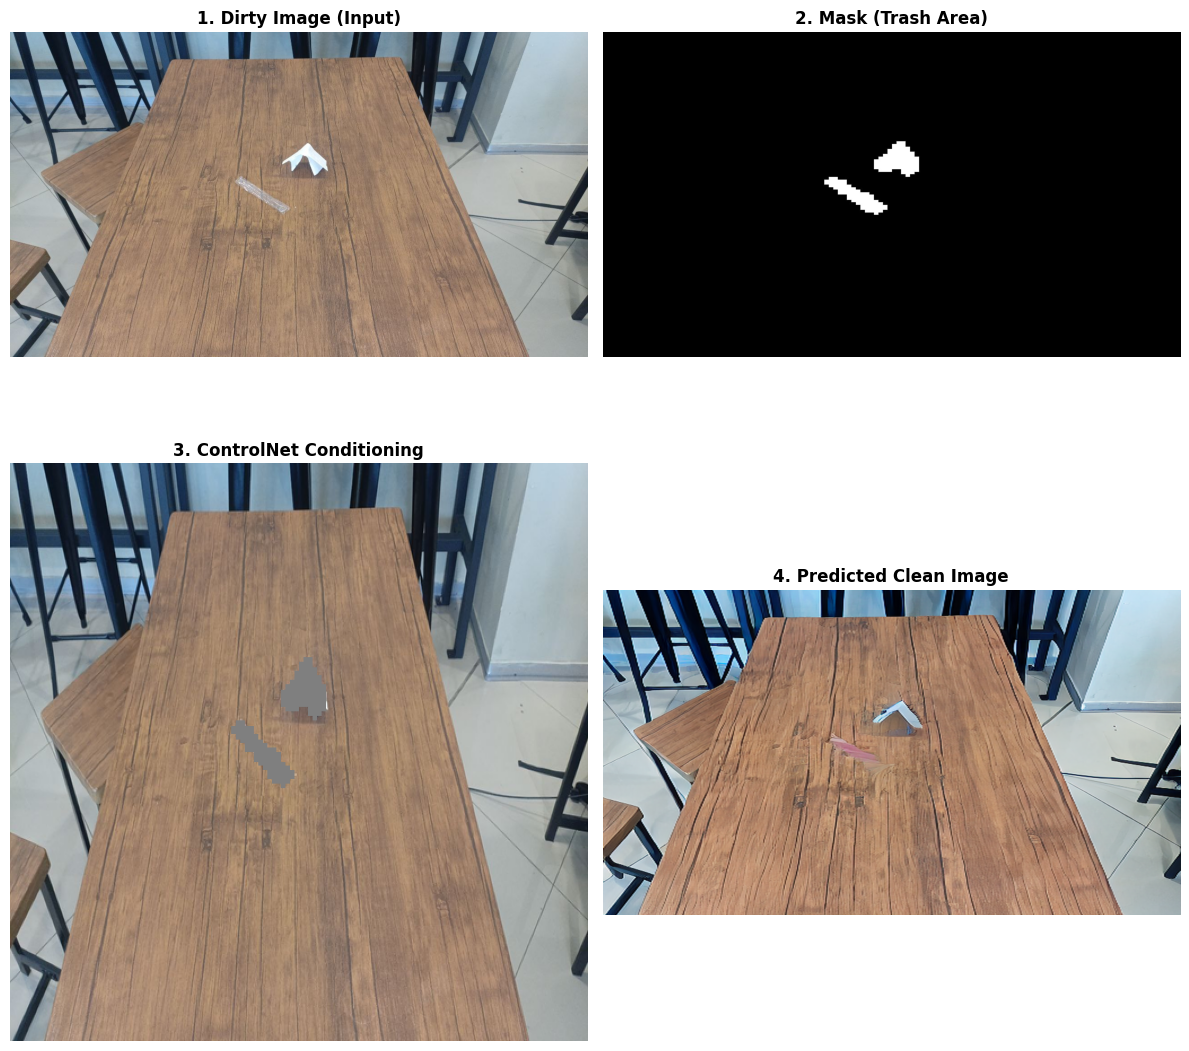


✅ Inference complete!
ControlNet helps maintain spatial structure while inpainting.


In [ ]:
""" Load Best Model """
print("=" * 60)
print("TESTING TRAINED MODEL")
print("=" * 60)

# Load ControlNet base model
print("\nLoading ControlNet base model...")
controlnet = ControlNetModel.from_pretrained(
    config.controlnet_model,
    torch_dtype=torch.float16
)

# Load LoRA weights
lora_path = f"{config.output_dir}/best_model"

if os.path.exists(lora_path):
    print(f"Loading best LoRA weights from: {lora_path}")
else:
    checkpoints = [d for d in os.listdir(config.output_dir) if d.startswith('checkpoint-')]
    if checkpoints:
        checkpoints.sort(key=lambda x: int(x.split('-')[1]))
        lora_path = f"{config.output_dir}/{checkpoints[-1]}"
        print(f"Best model not found, using: {lora_path}")
    else:
        lora_path = config.output_dir
        print(f"Using final model from: {lora_path}")

# Gunakan LoRA pada ControlNet
controlnet = PeftModel.from_pretrained(controlnet, lora_path)
controlnet.eval()

# Gabungkan bobot LoRA ke base model
print("Merging LoRA weights into base model...")
controlnet = controlnet.merge_and_unload()

# Buat pipeline
print("Creating inference pipeline...")
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    config.base_model,
    controlnet=controlnet,
    torch_dtype=torch.float16,
    safety_checker=None
)

device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = pipe.to(device)
print("✅ Model loaded successfully!")

""" Test Inference """
test_files = sorted([f for f in os.listdir(config.test_image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
test_image_name = test_files[3]

test_image_path = f"{config.test_image_dir}/{test_image_name}"
test_mask_path = f"{config.test_mask_dir}/{test_image_name}"

if os.path.exists(test_image_path):
    # Load gambar
    image = Image.open(test_image_path).convert("RGB")
    mask = Image.open(test_mask_path).convert("L")

    original_size = image.size

    # Resize ke 512x512 untuk diproses
    image_resized = image.resize((512, 512), Image.LANCZOS)
    mask_resized = mask.resize((512, 512), Image.LANCZOS)

    # Buat control image untuk ControlNet conditioning
    control_image = make_inpaint_condition(image_resized, mask_resized)

    print("🎨 Generating result with ControlNet...")
    result = pipe(
        prompt=config.train_prompt,
        image=image_resized,
        mask_image=mask_resized,
        control_image=control_image, 
        negative_prompt=config.negative_prompt,
        num_inference_steps=50,
        guidance_scale=7.5,
        controlnet_conditioning_scale=1.0,
        strength=0.99
    ).images[0]

    # Resize kembali ke ukuran awal
    result_original_size = result.resize(original_size, Image.LANCZOS)

    # Simpan hasil
    os.makedirs('/content/mydrive/MyDrive/Computer Vision/test_clean', exist_ok=True)
    result_original_size.save(f'/content/mydrive/MyDrive/Computer Vision/test_clean/{test_image_name}')
    print(f"✓ Saved to /content/mydrive/MyDrive/Computer Vision/test_clean/{test_image_name}")

    # Tampilkan
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(2, 2, figsize=(12, 12))

    axes[0, 0].imshow(image)
    axes[0, 0].set_title("1. Dirty Image (Input)", fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(mask, cmap='gray')
    axes[0, 1].set_title("2. Mask (Trash Area)", fontsize=12, fontweight='bold')
    axes[0, 1].axis('off')

    axes[1, 0].imshow(control_image)
    axes[1, 0].set_title("3. ControlNet Conditioning", fontsize=12, fontweight='bold')
    axes[1, 0].axis('off')

    axes[1, 1].imshow(result_original_size)
    axes[1, 1].set_title("4. Predicted Clean Image", fontsize=12, fontweight='bold')
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

    print("\n✅ Inference complete!")
    print("ControlNet helps maintain spatial structure while inpainting.")
else:
    print(f"❌ Test image not found: {test_image_path}")

## Generative Model Evaluation

**LPIPS Quality interpretation:**
- `<0.1`  = Excellent
- `<0.2`  = Good
- `<0.3`  = Acceptable
- `>0.3`  = Poor

**Perbandingan LPIPS tiap model:**

| Model            | Training Phase   | LPIPS  |
|------------------|------------------|--------|
| Stable Diffusion | Before training  | 0.2134 |
| Stable Diffusion | After training   | 0.1981 |
| ControlNet       | Before training  | 0.4495 |
| ControlNet       | After training   | 0.2390 |

Berdasarkan evaluasi menggunakan metrik LPIPS, terlihat bahwa proses training memberikan peningkatan performa yang signifikan, khususnya pada model ControlNet yang mengalami penurunan LPIPS dari 0.4495 (poor) menjadi 0.2390 (acceptable). Namun, Stable difussion menunjukkan hasil yang lebih unggul dibandingkan ControlNet dengan LPIPS setelah training sebesar 0.1981 (Good). Keunggulan ini menjadikan Stable Difussion lebih direkomendasikan untuk menghilangkan sampah dan mengganti area mask dengan gambar yang lebih natural.

Github: https://github.com/ChristopherTanamas/Trash-Segmentation-and-Removal/blob/main/UAS.ipynb 

# Komitmen Integritas
Di hadapan TUHAN yang hidup, saya menegaskan bahwa saya tidak memberikan maupun
menerima bantuan apapun—baik lisan, tulisan, maupun elektronik—di dalam ujian ini selain
daripada apa yang telah diizinkan oleh pengajar, dan tidak akan menyebarkan baik soal
maupun jawaban ujian kepada pihak lain.

**Kontribusi:**
1. 222200153 - Christopher (25%)
2. 222102311 - Elaine (25%)
3. 222102176 - Grace (25%)
4. 222101393 - Jemima (25%)